In [57]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.color import rgb2gray
from glob import glob
from skimage import io
from scipy.ndimage.morphology import binary_fill_holes
import random
import utilities
import pandas as pd
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage import morphology
from scipy import ndimage as ndi
from skimage.segmentation import mark_boundaries
from IPython import display
from collections import defaultdict
from imgaug import augmenters as iaa
#染色归一化函数
from normalization import normalizeStaining
from PIL import Image, ImageDraw
%matplotlib inline 
# Root directory of the project
ROOT_DIR = os.getcwd()
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
print(os.cpu_count())

28


In [58]:
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN', 'mrcnn'))
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))
from config import Config
import utils
import model as modellib
import visualize
from model import log
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [59]:
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN', 'mrcnn'))
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))
from config import Config
import utils
import model as modellib
import visualize
from model import log
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [60]:
class NucleiDataset(utils.Dataset):
    
    def load_datasets(self, folder_path):
        self.folder_path = folder_path
        self.add_class('nuclei', 1, 'Tumor')
        self.add_class('nuclei', 2, 'Lymphocyte')
        self.add_class('nuclei', 3, 'Others')
        image_ids = next(os.walk(folder_path))[1]
        for image_id in image_ids:
            self.add_image("nuclei", image_id=image_id, path=None)
            
    def load_image(self, image_id):
#         image_path = os.path.join(self.folder_path, self.image_info[image_id]['id'], str(self.image_info[image_id]['id'])+'.tiff')
        image_path = os.path.join(self.folder_path, self.image_info[image_id]['id'], 'image.png')
        print(image_path)
        image = cv2.imread(image_path)
#         print(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    
    def load_mask(self, image_id):
        mask=[]
        class_ids=[]
        label_path = os.path.join(self.folder_path, self.image_info[image_id]['id'])
        if os.path.exists(os.path.join(label_path,'label_t.png')):
            label_t_path = os.path.join(label_path,'label_t.png')
            label_t = cv2.imread(label_t_path , -1)
            mask_t = utilities.label_to_mask(label_t)
#             mask_t = mask_t.astype(bool)
            class_ids_t = np.ones(mask_t.shape[2], dtype=int)
        else:
            class_ids_t=[]
        if os.path.exists(os.path.join(label_path,'label_l.png')):
            label_l_path = os.path.join(label_path,'label_l.png')
            label_l = cv2.imread(label_l_path , -1)
            mask_l = utilities.label_to_mask(label_l)
#             mask_l = mask_l.astype(bool)
            q=mask_l.shape[2]
            class_ids_l=np.zeros(mask_l.shape[2],dtype=int)
            for i in range(q):
                class_ids_l[i]=2 
        else:
            class_ids_l=[]
        if os.path.exists(os.path.join(label_path,'label_o.png')):
            label_o_path = os.path.join(label_path,'label_o.png')
            label_o = cv2.imread(label_o_path , -1)
            mask_o = utilities.label_to_mask(label_o)
#             mask_o = mask_o.astype(bool)
            q=mask_o.shape[2]
            class_ids_o=np.zeros(mask_o.shape[2],dtype=int)
            for i in range(q):
                class_ids_o[i]=3    
        else:
            class_ids_o=[]
        if  class_ids_t!=[] and class_ids_l!=[] and class_ids_o!=[] :
            class_ids = np.concatenate((class_ids_t,class_ids_l),axis=0)
            class_ids = np.concatenate((class_ids,class_ids_o),axis=0)
            mask = np.concatenate((mask_t,mask_l),axis=-1)
            mask = np.concatenate((mask,mask_o),axis=-1)
        elif class_ids_t!=[] and class_ids_o!=[]  and class_ids_l==[]:
            class_ids = np.concatenate((class_ids_t,class_ids_o),axis=0)
            mask = np.concatenate((mask_t,mask_o),axis=-1)
        elif class_ids_l!=[] and class_ids_o!=[] and class_ids_t==[]:
            class_ids = np.concatenate((class_ids_l,class_ids_o),axis=0)
            mask = np.concatenate((mask_l,mask_o),axis=-1) 
        elif class_ids_l!=[] and class_ids_t!=[] and class_ids_o==[]:
            class_ids = np.concatenate((class_ids_l,class_ids_t),axis=0)
            mask = np.concatenate((mask_l,mask_t),axis=-1)             
        elif class_ids_t!=[] and class_ids_l==[] and class_ids_o==[]:
            class_ids=class_ids_t
            mask= mask_t
        elif class_ids_l!=[] and class_ids_t==[] and class_ids_o==[]:
            class_ids=class_ids_l
            mask= mask_l 
        elif class_ids_o!=[] and class_ids_t==[] and class_ids_l==[]:
            class_ids=class_ids_o
            mask= mask_o     
        return  mask.astype(bool),class_ids   

In [61]:
dataset_val = NucleiDataset()
dataset_val.load_datasets('vals_data')
dataset_val.prepare()

dataset_train = NucleiDataset()
dataset_train.load_datasets('trains_data')
dataset_train.prepare()

In [62]:
def merge_masks(masks, class_id, thresh):
    nrows, ncols, N = masks.shape
    pixels = [None] * N
    for i in range(N):
        mask = masks[:,:,i]
        xy = np.where(mask)
        pixels[i] = set(xy[0] * ncols + xy[1])
    
    indices = np.arange(N)
    picks = []
    indexes=[]
    while len(indices) > 0:
        i = indices[0]
        picks.append(i)
        suppress = [0]
        for pos in range(1, len(indices)):
            j = indices[pos]
            overlap = len(pixels[i] & pixels[j])
            iou = overlap / (len(pixels[i]) + len(pixels[j]) - overlap)
            if iou > thresh:
                masks[:,:,i] |= masks[:,:,j]
                suppress.append(pos)
                indexes.append(j)    
        indices = np.delete(indices, suppress)
#     print(indexes) 
    lists=class_id.tolist()
    for index in sorted(indexes, reverse=True):
        del lists[index]
    class_id=np.array(lists)    
    return masks[..., picks],class_id


In [63]:
def opening(masks, kernel):
    for i in range(masks.shape[2]):
        mask = masks[:,:,i]
        masks[:,:,i] = cv2.morphologyEx(masks[:,:,i].astype(np.uint8), cv2.MORPH_OPEN, kernel).astype(bool)
    return masks
def mask_to_coordinate(mask):
    coordinate = []
    for slc in range(mask.shape[2]):
        coordinate.append(set(zip(*np.nonzero(mask[:,:,slc]))))
    return coordinate

In [64]:
def evaluate(mask_true, mask_pred, threshes=np.arange(0.5, 1, 0.05)):

        coord_true = mask_to_coordinate(mask_true)
        coord_pred = mask_to_coordinate(mask_pred)
        iou = np.zeros([len(coord_true), len(coord_pred)], dtype=float)
        for i in range(len(coord_true)):
                for j in range(len(coord_pred)):
                        iou[i,j] = len(coord_true[i]&coord_pred[j])/len(coord_true[i]|coord_pred[j])
        TP = np.zeros(len(threshes))
        FP = np.zeros(len(threshes))
        FN = np.zeros(len(threshes))
        for ix, t in enumerate(threshes):
                I, J = np.nonzero(iou>t)
                TP[ix] = len(I)
                FP[ix] = len(coord_pred) - len(J)
                FN[ix] = len(coord_true) - len(I)

        return np.mean(TP/(TP+FP+FN)), np.mean(TP/(TP+FP)), np.mean(TP/(TP+FN))

def crop_image(image):
    height, width = image.shape[:2]
    n_h, n_w = math.ceil(height/1000), math.ceil(width/1000)
    h, w = height//n_h, width//n_w
    for i in range(n_h):
        for j in range(n_w):
            yield image[i*h:(i+1)*h, j*w:(j+1)*w]
            
            
def write_xml(masks, folder_path):
    with open(os.path.join(folder_path, 'contours.xml'),'w') as f:
        f.write('<?xml version="1.0" encoding="UTF-8"?>\n');
        f.write('<!-- MIPAV VOI file -->\n');
        f.write('<VOI xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">\n')
        f.write('<Unique-ID>1234567890</Unique-ID>\n')
        f.write('<Curve-type>0</Curve-type>\n')
        f.write('<Color>255,0,255,0</Color>\n')
        f.write('<Thickness>1</Thickness>\n')

        for i in range(masks.shape[-1]):
            _, contours, _ = cv2.findContours(masks[...,i].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            if contours:
                f.write('<Contour>\n')
                f.write('<Slice-number>0</Slice-number>\n')
                for contour in contours[0]:
                    f.write('<Pt>')
                    f.write(str(float(contour[0,0])))
                    f.write(',')
                    f.write(str(float(contour[0,1])))
                    f.write('</Pt>\n')
                f.write('</Contour>\n')

        f.write('</VOI>')

In [87]:

def plot_confusion_matrix(cm, title='Confusion Matrix', cmap = plt.cm.binary):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=30)
    labels=["Tumor","Lymphocyte","Others"]
    xlocations = np.array(range(len(labels)))
    plt.xticks(xlocations,labels,rotation=45,labelsize=16)
    plt.yticks(xlocations,labels,fontsize=16)
    plt.ylabel('Predicted Label',fontsize=16)
    plt.xlabel('Ground Truth',fontsize=16)
#     return img


In [66]:
def plot_confusion_matrixs(cm, title='Confusion Matrix', cmap = plt.cm.binary):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=16)
    labels=["Tumor","Lymphocyte","Others"]

    plt.colorbar(pad=0.1,fraction=0.1,aspect=10)
    xlocations = np.array(range(len(labels)))
    plt.xticks(xlocations,labels,rotation=45,fontsize=16)
    plt.yticks(xlocations,labels,fontsize=16)
    plt.ylabel('Predicted Label',fontsize=16)
    plt.xlabel('Ground Truth',fontsize=16)

In [68]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
def evaluates(mask_true, mask_pred,class_id_true,class_id_pred, threshes=0.5):

        coord_true = mask_to_coordinate(mask_true)
        coord_pred = mask_to_coordinate(mask_pred)
        iou = np.zeros([len(coord_true), len(coord_pred)], dtype=float)
        for i in range(len(coord_true)):
                for j in range(len(coord_pred)):
                        iou[i,j] = len(coord_true[i]&coord_pred[j])/len(coord_true[i]|coord_pred[j])
        
        I,J = np.nonzero(iou>0.5)
        class_true=[]
        class_pred=[]
        for i in range(len(I)):
            class_true.append(class_id_true[I[i]])
        for j in range(len(J)):
            class_pred.append(class_id_pred[J[j]])
        labels=["t","l","o"]
        tick_marks = np.array(range(len(labels))) + 0.5
        cm=confusion_matrix(class_true,class_pred)
        print(cm) 
        plot_confusion_matrix(cm)
        np.set_printoptions(precision=2)
        cm_normalized = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print (cm_normalized)
        plt.figure(figsize=(12,8), dpi=120)
        ind_array = np.arange(len(labels))
        x, y = np.meshgrid(ind_array, ind_array)
        for x_val, y_val in zip(x.flatten(), y.flatten()):
            c = cm_normalized[y_val][x_val]
            if (c > 0.01):
                plt.text(x_val, y_val, "%0.2f" %(c,), color='red', fontsize=7, va='center', ha='center')
#offset the tick
        plt.gca().set_xticks(tick_marks, minor=True)
        plt.gca().set_yticks(tick_marks, minor=True)
        plt.gca().xaxis.set_ticks_position('none')
        plt.gca().yaxis.set_ticks_position('none')
        plt.grid(True, which='minor', linestyle='-')
        plt.gcf().subplots_adjust(bottom=0.15)
 
        plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
#show confusion matrix
        plt.show()


In [69]:
class NucleiConfig(Config):

    # Give the configuration a recognizable name
    NAME = "Nucleus"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4
    
    BACKBONE = "resnet101"

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + color nucleus

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (16, 32, 64)  # anchor side in pixels
    
    RPN_TRAIN_ANCHORS_PER_IMAGE = 512
    
    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 256
    
    DETECTION_NMS_THRESHOLD = 0.5
    RPN_NMS_THRESHOLD = 0.5
    DETECTION_MIN_CONFIDENCE = 0.7
    DETECTION_MAX_INSTANCES = 200
    
    LEARNING_RATE = 0.0002
    RPN_ANCHOR_RATIOS = [0.5, 1, 2]
    WEIGHT_DECAY = 0.0001 # regularization
    
    USE_MINI_MASK = False
    ROI_POSITIVE_RATIO = 0.33
    
    MEAN_PIXEL = [172.37516002, 131.28276963, 157.18767967]
    
config = NucleiConfig()

In [70]:
class InferenceConfig(NucleiConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.7
    RPN_NMS_THRESHOLD = 0.7
    DETECTION_NMS_THRESHOLD = 0.5
    DETECTION_MAX_INSTANCES = 700
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024
    IMAGE_RESIZE_MODE = 'none'
    

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights  

'nucleus20190801T0758', 'mask_rcnn_nucleus_0001.h5' 
model_path = os.path.join(MODEL_DIR,'nucleus20190713T1311', 'mask_rcnn_nucleus_0023.h5'  )
# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Loading weights from  C:\Users\Yi\Documents\python_projects\nucleusSeg\logs\nucleus20190713T1311\mask_rcnn_nucleus_0023.h5


6
trains_data\0_12h (12)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


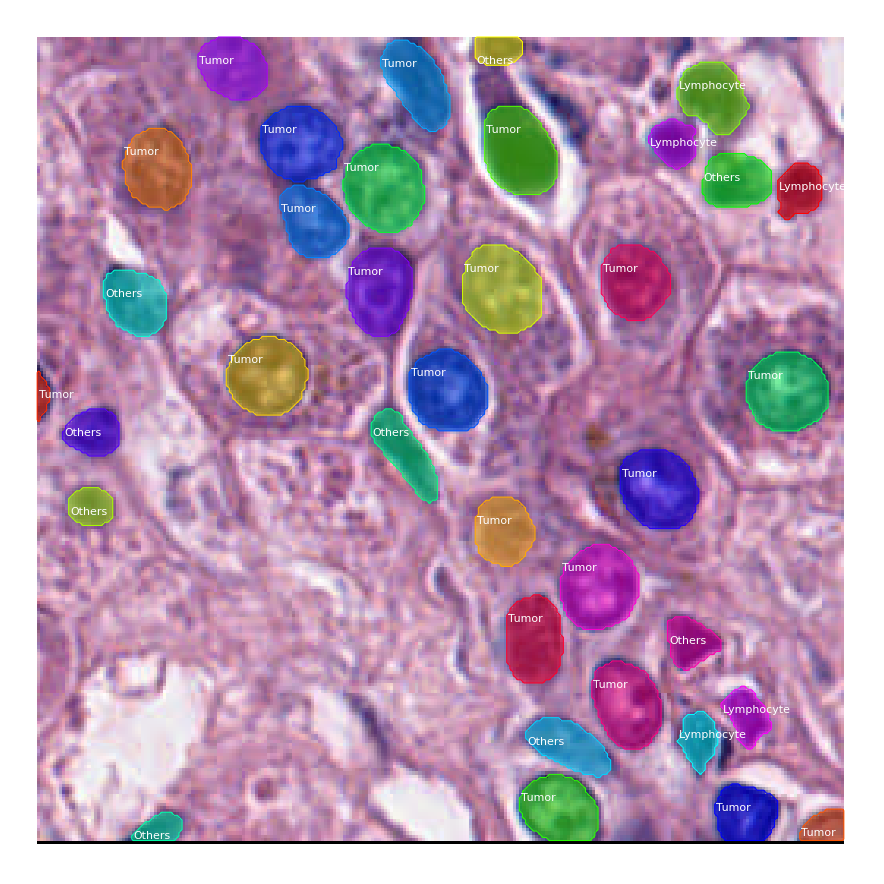

In [71]:
#无merge
plt.rcParams['figure.figsize'] = (16,16)
# Test on a random image
image_val_id =6
print(image_val_id)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, inference_config, 
                           image_val_id, use_mini_mask=False)
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, dataset_train.class_names,
                            show_bbox=False)

trains_data\0_12h (12)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


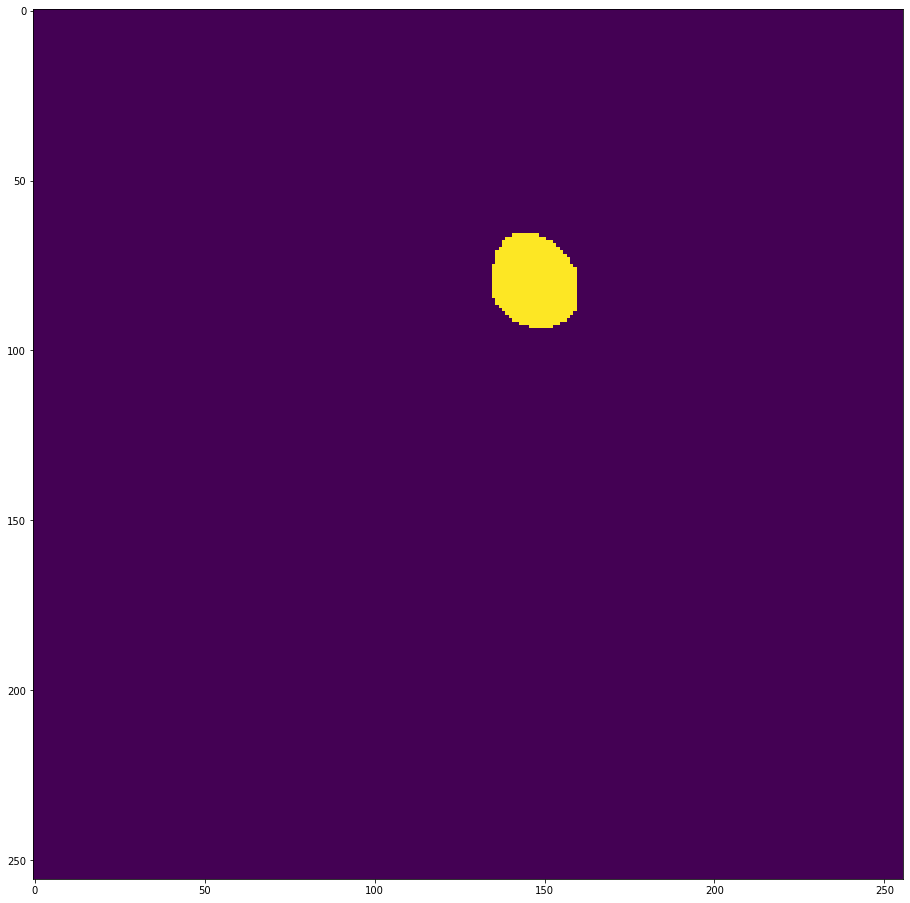

In [90]:
image_id = 6
image = dataset_train.load_image(image_id)
ask,mask, class_ids = dataset_train.load_mask(image_id)
plt.imshow(ask[:,:,0])
# # image1 = cv2.imread(image_path1,-1)
# # plt.imshow(image1)
# visualize.display_masks(image, mask, class_ids, dataset_train.class_names, limit=1)

trains_data\0_12h (12)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


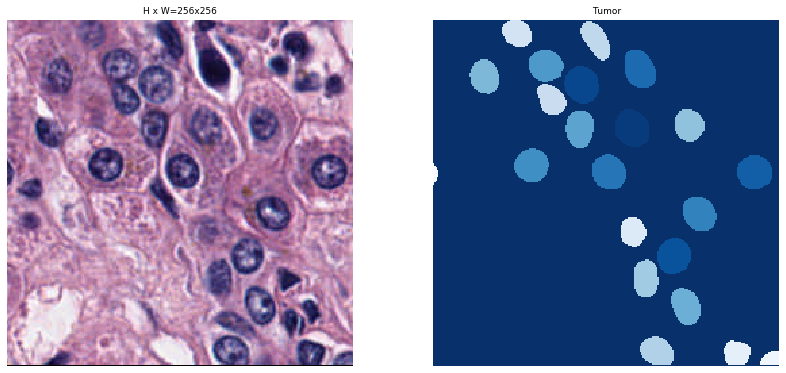

In [92]:
image_id = 6
image = dataset_train.load_image(image_id)
ask,mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=1)

1
trains_data\0_10\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


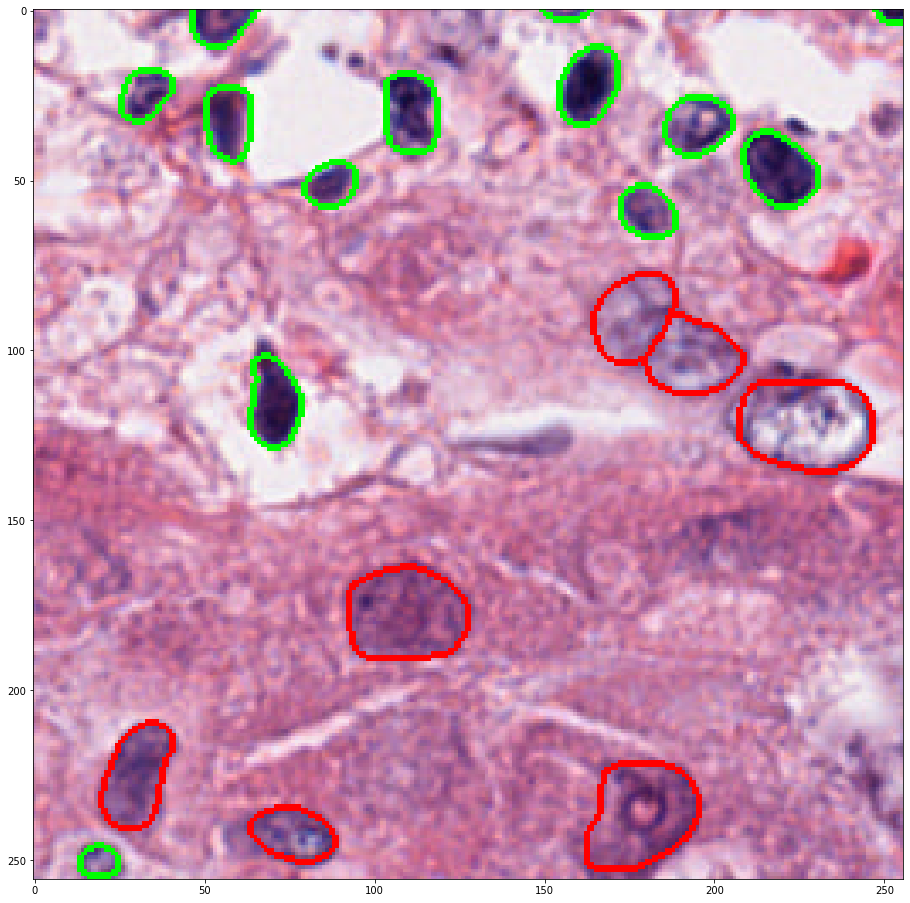

In [51]:
plt.rcParams['figure.figsize'] = (16,16)
# Test on a random image
image_val_id =1
print(image_val_id)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, inference_config, 
                           image_val_id, use_mini_mask=False)
# visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, dataset_train.class_names,
#                             show_bbox=False)
image_annotated = mark_boundaries(original_image, utilities.mask_to_label(gt_mask[:,:,gt_class_id==1]), color=(1, 0, 0), mode='thick')
image_annotated = mark_boundaries(image_annotated, utilities.mask_to_label(gt_mask[:,:,gt_class_id==2]), color=(0, 1, 0), mode='thick')
# plt.imshow(mark_boundaries(original_image, utilities.mask_to_label(gt_mask)))
image_annotated = mark_boundaries(image_annotated, utilities.mask_to_label(gt_mask[:,:,gt_class_id==3]), color=(0, 0, 1), mode='thick')
#ground truth
# plt.subplot(1,3,1)
plt.imshow(image_annotated)

1
trains_data\0_10\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


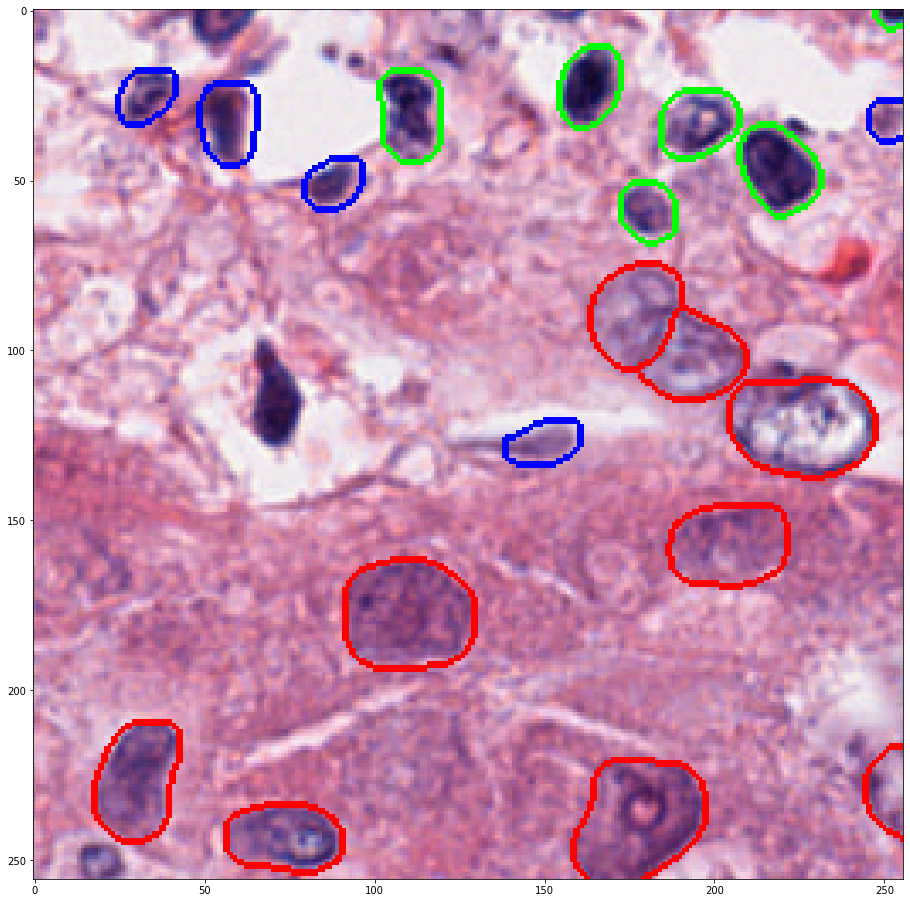

In [52]:
#无merge
plt.rcParams['figure.figsize'] = (16,16)
# Test on a random image
image_val_id =1
print(image_val_id)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, inference_config, 
                           image_val_id, use_mini_mask=False)
# visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, dataset_train.class_names,
#                             show_bbox=False)
image_annotated = mark_boundaries(original_image, utilities.mask_to_label(gt_mask[:,:,gt_class_id==1]), color=(1, 0, 0), mode='thick')
image_annotated = mark_boundaries(image_annotated, utilities.mask_to_label(gt_mask[:,:,gt_class_id==2]), color=(0, 1, 0), mode='thick')
# plt.imshow(mark_boundaries(original_image, utilities.mask_to_label(gt_mask)))
image_annotated = mark_boundaries(image_annotated, utilities.mask_to_label(gt_mask[:,:,gt_class_id==3]), color=(0, 0, 1), mode='thick')
#ground truth
# plt.subplot(1,3,1)
plt.imshow(image_annotated)

results = model.detect([original_image], verbose=1)
r = results[0]
class_ids=r['class_ids']
masks_new = r['masks']

masks_new,class_ids = merge_masks(r['masks'], r['class_ids'],0.3)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4))

for i in range(masks_new.shape[2]):
    masks_new[..., i] = cv2.morphologyEx(masks_new[:,:,i].astype(np.uint8), cv2.MORPH_DILATE, kernel).astype(bool)

image_annotateds = mark_boundaries(original_image, utilities.mask_to_label(masks_new[:,:,class_ids==1]), color=(1, 0, 0), mode='thick')
image_annotateds = mark_boundaries(image_annotateds, utilities.mask_to_label(masks_new[:,:,class_ids==2]), color=(0, 1, 0), mode='thick')
# plt.imshow(mark_boundaries(original_image, utilities.mask_to_label(gt_mask)))
image_annotateds = mark_boundaries(image_annotateds, utilities.mask_to_label(masks_new[:,:,class_ids==3]), color=(0, 0, 1), mode='thick')
#model
# plt.subplot(1,3,2)
plt.imshow(image_annotateds)


In [14]:
# image_val_ids = dataset_val.image_ids.tolist()
# plt.rcParams['figure.figsize'] = (16,16)
# for i in range

In [81]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
def evaluates(mask_true, mask_pred,class_id_true,class_id_pred, threshes=0.5):

        coord_true = mask_to_coordinate(mask_true)
        coord_pred = mask_to_coordinate(mask_pred)
        iou = np.zeros([len(coord_true), len(coord_pred)], dtype=float)
        for i in range(len(coord_true)):
                for j in range(len(coord_pred)):
                        iou[i,j] = len(coord_true[i]&coord_pred[j])/len(coord_true[i]|coord_pred[j])
        
        I,J = np.nonzero(iou>0.5)
        class_true=[]
        class_pred=[]
        for i in range(len(I)):
            class_true.append(class_id_true[I[i]])
        for j in range(len(J)):
            class_pred.append(class_id_pred[J[j]])
        return class_true,class_pred

In [78]:
dataset_val = NucleiDataset()
dataset_val.load_datasets('vals_data')
dataset_val.prepare()

dataset_train = NucleiDataset()
dataset_train.load_datasets('trains_data')
dataset_train.prepare()

In [85]:
def plot_confusion_matrixs(cm, title='Confusion Matrix', cmap = plt.cm.binary):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=30)
    labels=["Tumor","Lymphocyte","Others"]

    cb=plt.colorbar(pad=0.1,fraction=0.1,aspect=10)
    cb.ax.tick_params(labelsize=24) 
    xlocations = np.array(range(len(labels)))
#     ylocations = np.array(range(len(labels)))
    plt.xticks(xlocations,labels,rotation=45,fontsize=24)
    plt.yticks(xlocations,labels,fontsize=24)
    plt.ylabel('Predicted Label',fontsize=24)
    plt.xlabel('Ground Truth',fontsize=24)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Processing 1 images
image                    shape: (256, 256, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -153.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (100)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  109.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (101)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  109.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (102)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  116.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (103)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -118.37516  max:  116.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (104)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -118.28277  max:  113.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (105)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -118.28277  max:  113.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (106)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -112.28277  max:  111.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (107)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -113.28277  max:  116.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (108)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  116.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (109)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  109.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (110)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -140.37516  max:  109.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (111)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -142.37516  max:  112.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (112)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -142.37516  max:  112.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (113)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -112.28277  max:  111.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (114)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -129.37516  max:  116.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (115)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  116.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (116)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  106.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (117)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -145.37516  max:  109.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (118)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -145.37516  max:  109.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (119)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -142.37516  max:  111.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (120)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -113.28277  max:  111.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (121)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -130.37516  max:  111.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (122)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  108.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (123)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -145.37516  max:  109.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (124)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -145.37516  max:  109.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (125)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -113.28277  max:  109.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (126)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -130.37516  max:  108.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (127)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  108.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (128)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  111.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (129)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -152.37516  max:  109.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (130)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -150.37516  max:  109.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (132)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -140.37516  max:  109.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (133)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -142.37516  max:  108.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (134)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  108.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (136)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  109.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (137)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  109.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (138)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  113.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (139)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Mea

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  108.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (140)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  104.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (141)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (142)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -169.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (143)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -170.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (144)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -170.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (145)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -162.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (146)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (147)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (148)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -168.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (149)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -170.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (54)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (55)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (80)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  250.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -150.37516  max:  101.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (81)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  252.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -145.37516  max:  105.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (82)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  252.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -145.37516  max:  105.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (83)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  250.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  106.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (84)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  110.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (85)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -155.37516  max:  104.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (86)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -151.37516  max:  106.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (87)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -150.37516  max:  106.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (88)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -144.37516  max:  105.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (89)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -139.37516  max:  107.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (90)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  107.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (91)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  107.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (92)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -150.37516  max:  105.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (93)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -150.37516  max:  106.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (94)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  114.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (95)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  116.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (96)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  116.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (97)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  113.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (98)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  113.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\0_12h (99)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  111.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\14_10\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -143.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\14_11\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\14_2\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -156.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\14_3\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\14_4\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -154.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\14_5\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -150.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\14_6\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -150.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\14_7\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -154.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\14_8\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -152.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\14_9\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -156.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\15_0\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -162.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\15_1\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\15_10\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\15_11\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\15_2\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\15_3\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\15_4\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\15_5\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\15_6\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\15_7\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\15_8\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -155.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\15_9\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\16_0\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\16_1\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -153.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\16_10\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\16_11\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -148.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\16_2\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -153.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\16_3\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\16_4\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -156.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\16_5\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -163.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\16_6\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -163.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\16_7\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -154.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\16_8\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -156.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\16_9\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\17_0\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\17_1\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -168.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\17_10\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\17_11\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\17_12\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\17_13\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\17_14\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -155.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\17_15\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\17_2\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -149.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\17_3\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -149.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\17_4\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -149.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\17_5\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -155.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\17_6\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -143.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\17_7\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\17_8\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -163.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\17_9\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  116.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\18_1\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\18_10\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\18_11\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\18_2\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\18_4\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -146.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\18_5\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -156.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\18_6\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -153.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\18_7\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -155.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\18_8\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -144.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\18_9\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -156.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\19_0\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -153.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\19_1\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -165.37516  max:  122.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\19_2\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -171.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\19_3\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -159.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\19_4\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\19_5\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -171.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\19_6\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -159.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\19_7\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\19_8\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\1_0\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -163.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\1_1\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -163.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\1_10\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\1_11\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -169.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\1_12\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -165.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\1_13\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -165.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\1_14\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -165.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\1_15\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\1_2\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -162.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\1_3\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\1_4\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -162.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\1_5\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -162.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\1_6\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\1_7\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -168.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\1_8\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\1_9\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\20_0\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  122.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\20_1\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\20_2\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\20_3\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\20_4\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\20_5\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\20_6\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -150.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\20_7\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -150.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\20_8\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\21_0\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\21_1\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -155.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\21_10\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -141.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\21_11\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -150.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\21_2\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\21_3\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -146.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\21_4\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -152.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\21_5\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -148.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\21_6\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -142.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\21_7\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -142.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\21_8\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -146.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\21_9\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -152.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\22_0\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -163.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\22_1\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -163.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\22_10\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -154.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\22_2\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\22_3\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -163.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\22_4\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\22_5\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\22_6\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -145.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\22_7\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -153.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\22_8\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\22_9\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -162.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\23_0\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -146.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\23_1\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\23_2\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -156.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\23_3\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -126.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\23_4\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\23_5\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\23_6\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -127.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\23_7\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -155.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\23_8\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\24_0\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\24_1\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\24_11\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -152.37516  max:  118.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\24_12\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\24_15\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -139.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\24_2\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -155.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\24_3\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -153.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\24_4\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -148.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\24_5\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -153.37516  max:  118.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\24_6\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -149.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\24_7\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -149.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\24_8\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\25_0\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\25_1\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Mea

Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -159.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\25_2\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -159.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\25_3\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -159.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\25_4\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -162.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\25_5\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -165.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\25_6\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -159.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\25_7\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -162.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\25_8\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -165.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\26_0\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -165.37516  max:  115.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\26_1\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\26_2\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\26_3\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -165.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\26_4\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\26_5\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\26_6\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  117.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\26_7\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -163.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\26_8\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -165.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\27_0\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  117.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\27_1\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\27_10\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -162.37516  max:  116.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\27_2\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  116.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\27_3\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -154.37516  max:  116.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\27_4\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -168.37516  max:  115.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\27_6\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\27_7\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -159.37516  max:  115.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\27_8\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -153.37516  max:  118.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\27_9\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -156.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\28_0\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  117.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\28_1\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  116.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\28_10\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  116.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\28_11\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\28_2\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  118.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\28_3\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\28_4\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -162.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\28_5\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -162.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\28_6\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  118.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\28_7\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -162.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\29_0\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -140.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\29_1\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -141.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\29_2\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\29_3\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -146.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\29_4\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -144.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\29_5\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -156.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\29_6\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -146.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\29_7\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\29_8\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\2_0\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -168.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\2_1\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\2_10\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -159.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\2_11\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -159.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\2_12\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\2_13\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -165.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\2_14\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -163.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\2_15\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -159.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\2_2\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\2_3\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -159.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\2_4\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\2_5\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -169.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\2_6\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -169.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\2_7\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\2_8\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\2_9\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\3_1\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -165.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\3_10\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -155.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\3_11\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -156.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\3_2\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -168.37516  max:  122.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\3_3\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -162.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\3_5\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\3_6\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  122.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\3_7\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\3_8\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\3_9\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -154.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\4_0\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\4_1\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\4_2\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\4_2x\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\4_2x (19)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\4_2x (23)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\4_2x (24)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\4_2x (28)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -171.37516  max:  122.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\4_2x (29)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -171.37516  max:  122.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\4_2x (30)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -171.37516  max:  122.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\4_2x (31)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\4_2x (32)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\4_2x (33)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\4_2x (34)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\4_2x (35)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\4_2x (36)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -171.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\4_2x (37)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -170.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\4_2x (38)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -169.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\4_2x (39)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -170.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\4_2x (40)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -170.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\4_2x (41)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -169.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\4_2x (42)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\4_2x (7)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\4_3\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -168.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\4_4\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -170.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\4_5\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -168.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\4_6\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\4_7\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -170.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\4_8\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -170.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\l28_1\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\l28_1 (20)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\l28_1 (21)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\q0_7 (14)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -149.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\q0_7 (15)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -153.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\q0_7 (16)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -154.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\q0_7 (17)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -145.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\q0_7 (18)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -156.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\q0_7 (19)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -154.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\q0_7 (20)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -150.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\q0_7 (21)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -152.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\q0_7 (22)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\q0_7 (24)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\q0_7 (25)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\q0_7 (26)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -142.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\q0_7 (28)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\q0_7 (29)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -147.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\q0_7 (30)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  105.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\q0_7 (31)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  106.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\q0_7 (32)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  252.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -145.37516  max:  105.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\q0_7 (33)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  249.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -147.37516  max:  106.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\q0_7 (34)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -155.37516  max:  110.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\q0_7 (35)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -151.37516  max:  106.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\q0_7 (36)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -150.37516  max:  105.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\q0_7 (37)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -148.37516  max:  107.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\q0_7 (38)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -155.37516  max:  105.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\t0_12h (16)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\t0_12h (17)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\t0_12h (18)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\t0_12h (19)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\tt0_12h (72)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  106.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\tt0_12h (73)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  105.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\tt0_12h (74)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  105.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\tt0_12h (75)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  250.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:   99.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\tt0_12h (76)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  248.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:   99.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\tt0_12h (77)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  110.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\tt0_12h (78)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:   99.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\tt0_12h (79)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  101.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\tt0_12h (80)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\tt0_12h (81)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\tt0_12h (82)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\tt0_12h (83)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  104.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
vals_data\tt0_12h (84)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  106.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


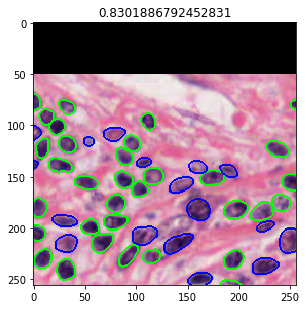

In [82]:
image_val_ids = dataset_val.image_ids.tolist()
print(image_val_ids)
class_t=[]
class_p=[]
class_l=[]
for i in range(len(image_val_ids)):
    plt.rcParams['figure.figsize'] = (16,16)
    # Test on a random image
    image_val_id = image_val_ids[i]
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_val_id, use_mini_mask=False)
    image_annotated = mark_boundaries(original_image, utilities.mask_to_label(gt_mask[:,:,gt_class_id==1]), color=(1, 0, 0), mode='thick')
    image_annotated = mark_boundaries(image_annotated, utilities.mask_to_label(gt_mask[:,:,gt_class_id==2]), color=(0, 1, 0), mode='thick')
    # plt.imshow(mark_boundaries(original_image, utilities.mask_to_label(gt_mask)))
    image_annotated = mark_boundaries(image_annotated, utilities.mask_to_label(gt_mask[:,:,gt_class_id==3]), color=(0, 0, 1), mode='thick')
    plt.subplot(1,3,1)
    plt.imshow(image_annotated)
    for k in range(len(gt_class_id)):
        class_l.append(gt_class_id[k])
    # plt.imshow(mark_boundaries(original_image, utilities.mask_to_label(gt_mask)))
    results = model.detect([original_image], verbose=1)
    r = results[0]
    class_ids=r['class_ids']
    masks_new = r['masks']
    # print("zhenshi",gt_class_id)
    # print("yuce",class_ids)
    masks_new,class_ids = merge_masks(r['masks'], r['class_ids'],0.3)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4))

    for i in range(masks_new.shape[2]):
        masks_new[..., i] = cv2.morphologyEx(masks_new[:,:,i].astype(np.uint8), cv2.MORPH_DILATE, kernel).astype(bool)

    image_annotateds = mark_boundaries(original_image, utilities.mask_to_label(masks_new[:,:,class_ids==1]), color=(1, 0, 0), mode='thick')
    image_annotateds = mark_boundaries(image_annotateds, utilities.mask_to_label(masks_new[:,:,class_ids==2]), color=(0, 1, 0), mode='thick')
    # plt.imshow(mark_boundaries(original_image, utilities.mask_to_label(gt_mask)))
    image_annotateds = mark_boundaries(image_annotateds, utilities.mask_to_label(masks_new[:,:,class_ids==3]), color=(0, 0, 1), mode='thick')
# 
    # plt.imshow(mark_boundaries(original_image, utilities.mask_to_label(masks_new)))
    plt.title(utilities.evaluate(gt_mask, masks_new, threshes=np.array([0.5])))
    class_true,class_pred=evaluates(gt_mask, masks_new,gt_class_id,class_ids, threshes=0.5)
    for j in range(len(class_true)):
        class_t.append(class_true[j])
        class_p.append(class_pred[j])


[[0.98 0.01 0.01]
 [0.05 0.91 0.04]
 [0.22 0.09 0.7 ]]


AttributeError: 'Text' object has no property 'labelsize'

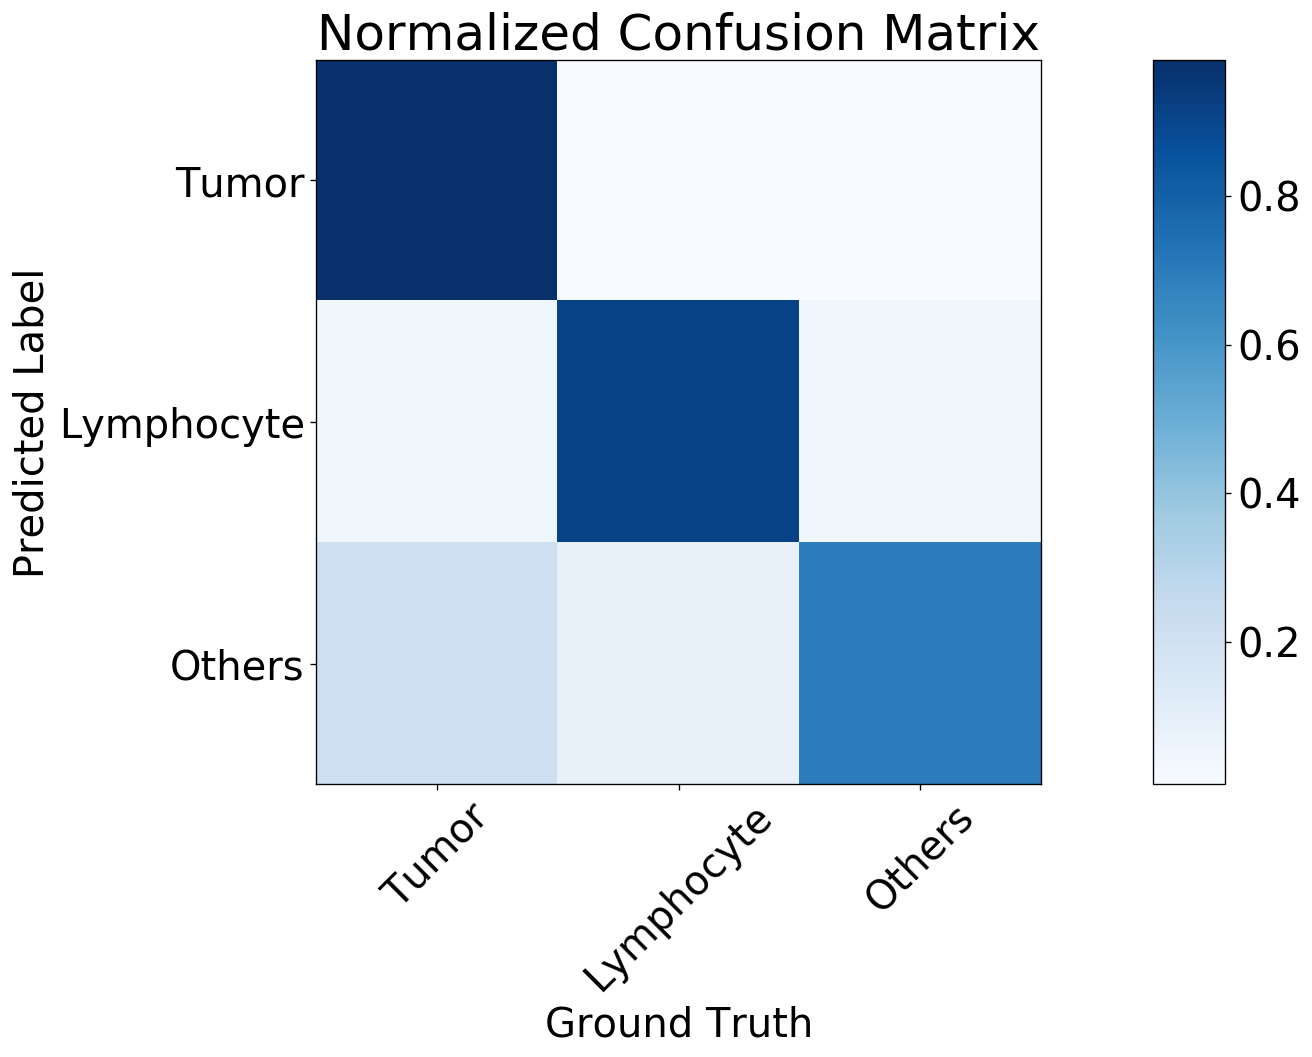

In [88]:
#val 1
cm = confusion_matrix(class_t, class_p)
np.set_printoptions(precision=2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm_normalized)
plt.figure(figsize=(12,8), dpi=120)
labels=["Tumor","Lymphocyte","Others"]
ind_array = np.arange(len(labels))
x, y = np.meshgrid(ind_array, ind_array)
plot_confusion_matrixs(cm_normalized, title='Normalized Confusion Matrix',cmap=plt.cm.Blues)
plot_confusion_matrix(cm_normalized, title='Normalized Confusion Matrix',cmap=plt.cm.Blues)
plt.show()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32
trains_data\0_10\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Mea

Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_11\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -168.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (10)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (11)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (12)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (13)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (14)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (15)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (16)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (17)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (18)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (19)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (2)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (20)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (21)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (22)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (23)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -140.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (24)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -143.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (25)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -143.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (26)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (27)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (28)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (29)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (3)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (30)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (31)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (32)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (33)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (34)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (35)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (36)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (37)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (38)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -150.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (39)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -150.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (4)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -168.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (40)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -149.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (41)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (42)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (43)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -153.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (44)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -154.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (45)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -154.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (46)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (47)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (48)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -156.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (49)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -154.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (5)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (50)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -154.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (51)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (52)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (53)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (56)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (57)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (58)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (59)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (6)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (60)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (61)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -142.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (62)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (63)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -149.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (64)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (65)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -149.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (66)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (67)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (68)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (69)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (7)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -165.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (70)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  104.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (71)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  106.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (72)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  106.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (73)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  105.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (74)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  105.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (75)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  250.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:   99.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (76)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  248.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:   99.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (77)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  110.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (78)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:   99.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (79)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  101.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (8)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -170.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_12h (9)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_3\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_4\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -155.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_5\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_6\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_7\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_8\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -154.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\0_9\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\10_0\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -165.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\10_1\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -169.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\10_2\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\10_3\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\10_4\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\10_5\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\10_6\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\10_7\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -169.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\10_8\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\11_1\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -148.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\11_2\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -148.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\11_3\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\11_4\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -143.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\11_5\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -156.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\11_6\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -143.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\11_7\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -154.37516  max:  108.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\11_8\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -146.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\12_0\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -163.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\12_1\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -154.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\12_2\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -151.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\12_3\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -150.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\12_4\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -163.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\12_5\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -154.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\12_6\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -159.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\12_7\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -155.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\12_8\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -155.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\13_0\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -156.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\13_1\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -168.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\13_2\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\13_3\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -156.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\13_4\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\13_5\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -151.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\13_6\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -150.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\13_7\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\13_8\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\14_0\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -151.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\14_1\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -156.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\24_10\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -141.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\24_13\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -141.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\24_14\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -136.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\24_9\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -138.37516  max:  118.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\27_11\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -162.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\27_5\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\28_8\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -165.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\28_9\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -165.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\4_10\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -171.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\4_11\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\4_12\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\4_13\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\4_14\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -171.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\4_15\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -171.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\4_9\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\5_0\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\5_1\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\5_10\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\5_11\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\5_12\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\5_13\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\5_14\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\5_15\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -170.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\5_2\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -171.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\5_3\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -168.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\5_4\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\5_5\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\5_6\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\5_7\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\5_8\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\5_9\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\6_0\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -148.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\6_1\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -148.37516  max:  117.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\6_10\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -163.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\6_11\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -152.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\6_2\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\6_3\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\6_4\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\6_5\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\6_6\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\6_7\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\6_8\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\6_9\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -163.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\7_0\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\7_1\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -163.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\7_10\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -169.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\7_11\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\7_12\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\7_13\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\7_14\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\7_15\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\7_2\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\7_3\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\7_4\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\7_5\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\7_6\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -169.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\7_7\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\7_8\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\7_9\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -169.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\8_0\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\8_1\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\8_10\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -170.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\8_11\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -170.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\8_2\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\8_3\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\8_4\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -169.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\8_5\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\8_6\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -171.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\8_7\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\8_8\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\8_9\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\9_0\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:75: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  122.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\9_1\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -169.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\9_2\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -165.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\9_4\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -170.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\9_5\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -162.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\9_7\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -170.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (10)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (100)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (101)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (102)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (103)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (104)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (105)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (106)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -169.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (107)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (108)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (109)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (11)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (110)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (111)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (112)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (113)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (114)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (115)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (116)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (117)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  122.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (118)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (119)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  115.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (12)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (120)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  115.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (121)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (122)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (123)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  118.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (124)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  118.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (125)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (126)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (127)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (128)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (129)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (13)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (130)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (131)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  254.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -151.37516  max:  118.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (132)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  254.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (133)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -151.37516  max:  115.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (134)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  254.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -155.37516  max:  118.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (135)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  254.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (136)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -163.37516  max:  117.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (137)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  117.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (138)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  113.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (139)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  116.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (14)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (140)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -171.37516  max:  115.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (141)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  116.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (142)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  116.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (143)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -168.37516  max:  113.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (15)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (16)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (17)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (18)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (19)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (2)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  116.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (22)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (23)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  118.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (24)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  117.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (25)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (26)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (27)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (28)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (29)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (3)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  113.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (30)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (31)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (32)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (33)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (34)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  118.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (35)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  118.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (36)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (37)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (38)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (39)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (4)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (40)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (41)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (42)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (43)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (44)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (45)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (46)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (47)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (48)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  122.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (49)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (5)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (50)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  122.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (51)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  117.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (52)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  114.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (53)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  113.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (54)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  118.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (55)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  113.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (56)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (57)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (58)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  122.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (59)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -171.37516  max:  122.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (6)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (60)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (61)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (62)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (63)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (64)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (65)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (66)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (67)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (68)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (69)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (7)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (70)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (71)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  122.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (72)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (73)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (74)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (75)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (76)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  122.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (77)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  122.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (78)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (79)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (8)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (80)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  122.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (81)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  122.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (82)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (83)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  122.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (84)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  122.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (85)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (86)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (87)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (88)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  122.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (89)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (9)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (90)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  122.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (91)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  122.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (92)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  122.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (93)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (94)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (95)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (96)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (97)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (98)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\l28_1 (99)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -171.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\q0_7\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -168.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\q0_7 (10)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -143.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\q0_7 (11)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -143.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\q0_7 (12)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -149.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\q0_7 (13)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -146.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\q0_7 (2)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\q0_7 (3)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\q0_7 (39)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:75: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -139.37516  max:  106.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\q0_7 (4)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -171.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\q0_7 (42)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -118.37516  max:  116.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\q0_7 (43)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -118.28277  max:  113.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\q0_7 (44)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.37516  max:  111.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\q0_7 (45)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -119.28277  max:  116.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\q0_7 (46)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -140.37516  max:  109.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\q0_7 (47)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -142.37516  max:  109.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\q0_7 (48)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -112.28277  max:  111.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\q0_7 (49)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -130.37516  max:  116.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\q0_7 (5)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -168.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\q0_7 (50)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -146.37516  max:  108.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\q0_7 (51)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -145.37516  max:  109.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\q0_7 (52)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -113.28277  max:  109.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\q0_7 (53)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -130.37516  max:  108.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\q0_7 (56)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -156.37516  max:  113.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\q0_7 (57)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -147.37516  max:  108.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\q0_7 (58)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -169.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\q0_7 (59)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -170.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\q0_7 (6)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -138.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\q0_7 (60)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -170.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\q0_7 (61)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -162.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\q0_7 (62)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -168.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\q0_7 (63)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\q0_7 (64)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\q0_7 (7)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -140.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\q0_7 (8)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -140.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\q0_7 (9)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -140.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (1)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Mea

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (10)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Mea

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (100)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (101)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (102)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -156.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (103)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -165.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (104)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -165.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (105)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -159.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (106)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -159.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (107)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (108)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (109)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (11)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (110)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -165.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (111)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -165.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (112)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (113)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -159.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (114)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (115)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (116)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (117)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (118)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (119)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (12)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (120)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (121)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (122)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (123)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -165.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (124)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -165.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (125)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -168.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (126)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -168.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (127)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -162.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (128)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (129)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (13)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -159.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (130)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -165.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (131)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -165.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (132)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -168.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (133)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -168.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (134)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -162.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (135)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (136)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (137)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (138)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (139)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -163.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (14)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (140)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (141)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -162.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (142)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (143)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (144)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (145)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (146)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -163.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (147)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (148)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (149)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (15)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (150)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (151)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (152)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (153)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (154)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (155)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (156)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (157)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (158)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (159)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (16)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Mea

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (160)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (161)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (162)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (163)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (164)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (165)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (166)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (167)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (168)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (169)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -168.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (17)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (170)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (171)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (172)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -170.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (173)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (174)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (175)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -170.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (176)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (177)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (178)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -170.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (179)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -168.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (18)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (180)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -169.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (181)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -169.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (182)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -170.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (183)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (184)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (185)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (186)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (187)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (188)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -171.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (189)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -171.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (19)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Mea

Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (190)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (191)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (192)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (193)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (194)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (195)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -171.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (196)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -171.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (197)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (198)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (199)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (2)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Mea

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (20)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (200)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (201)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (202)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (203)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (204)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (205)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (206)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (207)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (208)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (209)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (21)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (210)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (211)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (212)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (213)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (214)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -171.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (215)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -171.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (216)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -168.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (217)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (218)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (219)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (22)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (220)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (221)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -168.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (222)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -168.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (223)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Mea

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -168.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (224)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (225)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (226)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (227)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (228)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (229)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (23)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (230)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -165.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (231)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (232)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (233)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (234)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (235)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -165.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (236)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (237)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (238)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (239)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (24)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (240)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (241)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (242)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -165.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (243)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (244)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -170.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (245)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (246)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (247)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (248)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (249)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (25)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (250)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (251)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (252)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (253)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (254)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (255)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  117.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (256)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (257)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (258)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (259)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (26)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Mea

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (261)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -152.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (262)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (263)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (264)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (265)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -154.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (266)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (267)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  118.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (268)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (269)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (27)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Mea

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (270)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (271)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -155.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (272)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (273)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (274)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (275)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (276)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (277)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (278)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (279)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Mea

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (28)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  116.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (280)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (281)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (282)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (283)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (284)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (285)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (286)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (287)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  116.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (288)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (289)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (29)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (290)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (291)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (292)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (293)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (294)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (295)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (296)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (297)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (298)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (299)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (3)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (30)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (300)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (301)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (302)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (303)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (304)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (305)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -169.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (306)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -169.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (307)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (308)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (309)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (31)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (310)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (311)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -169.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (312)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -169.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (313)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -169.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (314)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (315)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (316)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (317)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -168.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (318)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -169.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (319)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -169.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (32)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (320)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (321)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (322)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (323)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  122.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (324)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -168.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (325)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -168.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (326)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (327)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (328)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (329)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (33)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (330)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (331)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (332)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (333)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (334)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (335)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (336)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (337)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (338)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (339)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (34)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (340)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (341)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (342)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (343)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (344)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (345)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (346)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -171.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (347)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -171.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (348)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (349)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (35)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (350)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (351)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -169.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (352)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (353)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (354)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -171.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (355)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (356)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (357)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (358)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (359)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (36)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (360)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (361)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -170.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (362)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -170.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (363)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (364)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (365)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (366)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (367)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (368)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (369)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (37)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (370)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (372)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -169.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (373)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (374)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (375)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (376)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -162.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (377)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -169.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (378)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -169.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (379)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (38)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (380)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -170.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (381)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -170.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (382)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (383)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -170.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (384)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -170.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (385)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (386)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (387)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (388)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (389)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (39)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (390)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (391)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (392)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (393)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (394)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -169.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (395)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -169.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (396)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (397)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (398)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (399)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (4)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (40)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -168.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (400)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (401)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (402)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (403)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (404)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (405)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (406)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (407)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (408)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (409)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (41)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (410)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (411)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (413)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -148.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (414)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (415)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (416)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (417)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (418)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -143.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (419)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -144.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (42)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (420)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -156.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (421)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (422)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (423)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -147.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (424)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -143.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (425)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -156.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (426)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (428)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -147.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (429)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -154.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (43)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -162.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (430)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -154.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (431)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (432)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (433)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  117.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (434)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  108.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (435)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (436)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (437)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (438)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (439)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (44)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -162.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (440)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (441)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (442)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (443)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -154.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (444)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -163.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (445)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -163.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (446)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (447)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (448)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -154.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (449)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -163.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (45)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (450)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -163.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (451)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (452)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (453)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -159.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (454)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -155.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (455)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -155.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (456)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (457)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (458)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (459)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (46)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (460)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (461)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (462)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (463)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (464)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (465)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (466)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (467)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (468)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -156.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (469)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (47)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -168.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (470)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (471)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (472)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -156.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (473)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (474)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (475)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (476)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -155.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (477)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -142.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (478)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -153.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (479)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (48)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (480)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (481)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (482)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (483)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (484)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (485)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (486)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (487)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (488)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (489)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (49)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (490)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (491)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (492)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (493)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -151.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (494)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -150.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (495)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -150.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (496)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -152.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (497)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -152.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (498)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (499)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (5)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (50)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -162.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (500)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -154.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (501)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -150.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (502)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -150.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (503)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -154.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (504)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -154.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (505)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (506)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (507)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -154.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (508)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -152.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (509)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -144.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (51)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -162.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (510)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -154.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (511)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (512)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (513)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (514)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (515)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (516)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (517)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (518)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (519)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (52)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (520)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (521)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (522)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (523)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (524)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (525)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (526)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (527)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (528)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -159.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (529)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (53)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (530)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (531)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (532)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (533)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (534)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (535)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (536)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (537)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (538)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (539)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (54)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -169.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (540)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (541)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (542)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (543)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (544)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (545)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (546)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (547)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (548)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (549)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (55)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (550)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (551)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (552)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (553)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (554)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (555)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (556)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (557)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (558)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (559)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (56)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (560)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (561)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (562)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (563)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -151.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (564)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -153.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (565)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -153.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (566)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -152.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (567)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (568)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (569)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -156.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (57)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (570)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -156.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (571)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -163.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (572)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -163.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (573)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -154.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (574)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (575)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (576)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -156.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (577)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (578)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (579)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -163.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (58)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (580)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -154.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (581)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (582)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (583)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (584)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (585)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (586)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (587)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (588)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (589)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (59)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (590)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (591)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (592)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (593)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (594)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (595)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -148.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (596)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -155.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (597)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -155.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (598)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -149.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (599)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -142.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (6)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (60)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (600)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (601)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (602)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -151.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (603)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -155.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (604)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -155.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (605)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -143.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (606)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (607)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (608)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (609)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -151.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (61)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -169.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (611)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (612)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (613)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (614)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (615)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (616)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -163.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (617)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -154.37516  max:  118.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (618)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (619)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (62)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (620)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (621)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (622)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (623)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (624)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (625)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -150.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (626)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -149.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (627)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (628)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (629)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (63)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -165.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (630)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (631)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (632)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  118.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (633)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (634)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (635)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (636)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:75: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -146.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (637)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (638)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (639)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (64)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (640)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (641)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (642)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -153.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (643)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -155.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (644)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -156.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (645)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (646)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (647)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -153.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (648)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -155.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (649)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (65)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (650)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (651)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -156.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (652)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -156.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (653)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -156.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (654)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -153.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (655)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -155.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (656)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (657)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (658)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -156.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (659)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -156.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (66)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (660)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (661)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (662)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (663)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (664)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (665)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (666)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (667)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (668)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (669)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  114.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (67)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (670)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (671)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (672)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  118.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (673)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (675)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -165.37516  max:  122.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (676)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -171.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (677)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  113.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (678)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (679)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -159.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (68)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (680)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (681)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -171.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (682)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (683)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (684)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -159.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (685)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (686)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (687)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (688)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (689)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (69)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (690)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  117.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (691)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  117.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (692)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (693)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  118.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (694)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (695)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (696)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  118.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (697)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (698)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  122.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (699)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (7)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (70)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (700)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -155.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (701)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (702)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (703)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  122.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (704)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (705)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (706)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (707)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (708)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (709)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (71)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (710)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (711)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -150.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (712)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (713)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (714)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (715)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (716)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (717)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (718)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (719)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (72)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (720)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (721)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (722)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (723)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (724)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (725)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -152.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (726)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (727)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (728)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  122.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (729)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -152.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (73)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (730)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -152.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (731)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (732)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (733)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  113.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (734)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -150.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (735)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -150.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (736)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -142.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (737)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (738)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (739)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -142.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (74)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (740)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -142.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (741)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -146.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (742)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (743)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (744)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -148.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (745)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -141.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (746)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -150.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (747)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (748)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (749)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (75)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (750)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (751)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (752)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (753)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -163.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (754)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -163.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (755)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (756)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (757)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (758)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (759)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -163.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (76)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (760)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (761)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (762)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (763)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (764)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -163.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (765)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (766)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (767)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (768)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (769)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -155.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (77)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (770)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -159.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (771)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (772)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (773)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (774)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -143.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (775)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -153.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (776)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (777)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (778)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -162.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (779)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -154.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (78)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (780)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -155.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (781)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (782)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (783)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (784)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (785)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (786)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (787)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (788)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (789)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (79)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (790)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (791)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (792)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -146.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (793)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (794)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (795)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (796)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (797)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -135.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (798)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (799)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (8)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -168.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (80)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (800)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -135.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (801)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -155.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (802)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (803)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (804)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (805)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (806)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  118.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (807)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (808)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (809)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (81)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (810)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (811)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (812)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (813)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (814)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (815)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (816)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -155.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (817)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -155.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (818)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -149.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (819)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (82)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -169.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (820)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (821)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -152.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (822)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -153.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (823)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -153.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (824)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -149.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (825)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -149.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (826)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (827)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (828)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -138.37516  max:  117.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (829)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -151.37516  max:  117.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (83)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -169.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (830)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -151.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (831)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -145.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (832)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -151.37516  max:  118.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (833)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  116.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (834)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (835)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (836)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -138.37516  max:  118.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (837)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -138.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (838)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -141.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (839)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -151.37516  max:  118.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (84)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -159.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (840)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  118.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (841)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (842)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (843)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -141.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (844)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -136.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (845)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -136.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (846)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -141.37516  max:  118.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (847)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  118.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (848)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  118.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (849)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (85)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -159.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (850)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (851)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (852)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (853)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (854)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (855)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (856)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (857)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Mea

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (858)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Mea

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (859)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Mea

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (86)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (860)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (861)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -159.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (862)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Mea

Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -159.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (863)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Mea

Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -159.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (864)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (865)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (866)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (867)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -162.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (868)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Mea

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -165.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (869)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -162.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (87)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (870)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Mea

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -165.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (871)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (872)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Mea

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (873)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Mea

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (874)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Mea

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (875)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Mea

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (876)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  110.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (877)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  118.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (878)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (879)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (88)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (880)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (881)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  115.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (882)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  118.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (883)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (884)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -163.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (885)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (886)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (887)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  115.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (888)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (889)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -165.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (89)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -169.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (890)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (891)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (892)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -163.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (893)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -163.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (894)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -165.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (895)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (896)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (897)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (898)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (899)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (9)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (90)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -169.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (900)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  108.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (901)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  117.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (902)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (903)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (904)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  116.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (905)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  116.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (906)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  113.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (907)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  115.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (908)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -168.37516  max:  117.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (909)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  117.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (91)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (910)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -162.37516  max:  116.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (911)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -157.37516  max:  116.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (912)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -154.37516  max:  116.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (913)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  115.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (914)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  115.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (915)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -168.37516  max:  115.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (916)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (917)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (918)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  115.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (919)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  108.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (92)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (920)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -152.37516  max:  118.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (921)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -155.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (922)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -159.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (923)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  108.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (924)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  118.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (925)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (926)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (927)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (928)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (929)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  117.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (93)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:75: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (930)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  115.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (931)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  117.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (932)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  117.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (933)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  111.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (934)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  115.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (935)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (936)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (937)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  115.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (938)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  117.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (939)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  117.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (94)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (940)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -159.37516  max:  118.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (941)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (942)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (943)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (944)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (945)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -162.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (946)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -162.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (947)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  118.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (948)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (949)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -162.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (95)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (950)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (951)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (952)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  116.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (953)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -164.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (954)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (955)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (956)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (957)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (958)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (959)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  116.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (96)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (960)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (961)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (962)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -140.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (963)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (964)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (965)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (966)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (967)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (968)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -140.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (969)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -144.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (97)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -162.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (970)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (971)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (972)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (973)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -136.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (974)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -144.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (975)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -156.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (976)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (977)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -139.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (978)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (979)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (98)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -159.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (980)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (981)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (982)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  121.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (983)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (985)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -170.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (986)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (987)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


trains_data\y0_4 (99)\image.png


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Processing 1 images
image                    shape: (256, 256, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -159.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16128, 4)         min:   -0.17747  max:    1.11472  float32


c:\users\yi\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


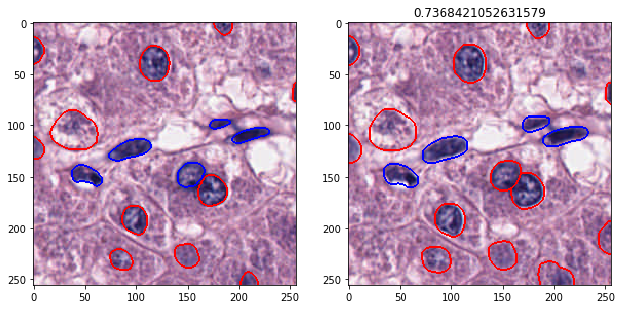

In [89]:
image_train_ids = dataset_train.image_ids.tolist()
print(image_train_ids)
class_t=[]
class_p=[]
class_l=[]
for i in range(len(image_train_ids)):
    plt.rcParams['figure.figsize'] = (16,16)
    # Test on a random image
    image_train_id = image_train_ids[i]
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_train, inference_config, 
                               image_train_id, use_mini_mask=False)
    image_annotated = mark_boundaries(original_image, utilities.mask_to_label(gt_mask[:,:,gt_class_id==1]), color=(1, 0, 0), mode='thick')
    image_annotated = mark_boundaries(image_annotated, utilities.mask_to_label(gt_mask[:,:,gt_class_id==2]), color=(0, 1, 0), mode='thick')
    # plt.imshow(mark_boundaries(original_image, utilities.mask_to_label(gt_mask)))
    image_annotated = mark_boundaries(image_annotated, utilities.mask_to_label(gt_mask[:,:,gt_class_id==3]), color=(0, 0, 1), mode='thick')
    plt.subplot(1,3,1)
    plt.imshow(image_annotated)
    for k in range(len(gt_class_id)):
        class_l.append(gt_class_id[k])
    # plt.imshow(mark_boundaries(original_image, utilities.mask_to_label(gt_mask)))
    results = model.detect([original_image], verbose=1)
    r = results[0]
    class_ids=r['class_ids']
    masks_new = r['masks']
    # print("zhenshi",gt_class_id)
    # print("yuce",class_ids)
    masks_new,class_ids = merge_masks(r['masks'], r['class_ids'],0.3)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4))

    for i in range(masks_new.shape[2]):
        masks_new[..., i] = cv2.morphologyEx(masks_new[:,:,i].astype(np.uint8), cv2.MORPH_DILATE, kernel).astype(bool)

    image_annotateds = mark_boundaries(original_image, utilities.mask_to_label(masks_new[:,:,class_ids==1]), color=(1, 0, 0), mode='thick')
    image_annotateds = mark_boundaries(image_annotateds, utilities.mask_to_label(masks_new[:,:,class_ids==2]), color=(0, 1, 0), mode='thick')
    # plt.imshow(mark_boundaries(original_image, utilities.mask_to_label(gt_mask)))
    image_annotateds = mark_boundaries(image_annotateds, utilities.mask_to_label(masks_new[:,:,class_ids==3]), color=(0, 0, 1), mode='thick')
    plt.subplot(1,3,2)
    plt.imshow(image_annotateds)
    # plt.imshow(mark_boundaries(original_image, utilities.mask_to_label(masks_new)))
    plt.title(utilities.evaluate(gt_mask, masks_new, threshes=np.array([0.5])))
    class_true,class_pred=evaluates(gt_mask, masks_new,gt_class_id,class_ids, threshes=0.5)
    for j in range(len(class_true)):
        class_t.append(class_true[j])
        class_p.append(class_pred[j])


[[0.99 0.   0.  ]
 [0.01 0.97 0.02]
 [0.18 0.02 0.81]]


AttributeError: 'Text' object has no property 'labelsize'

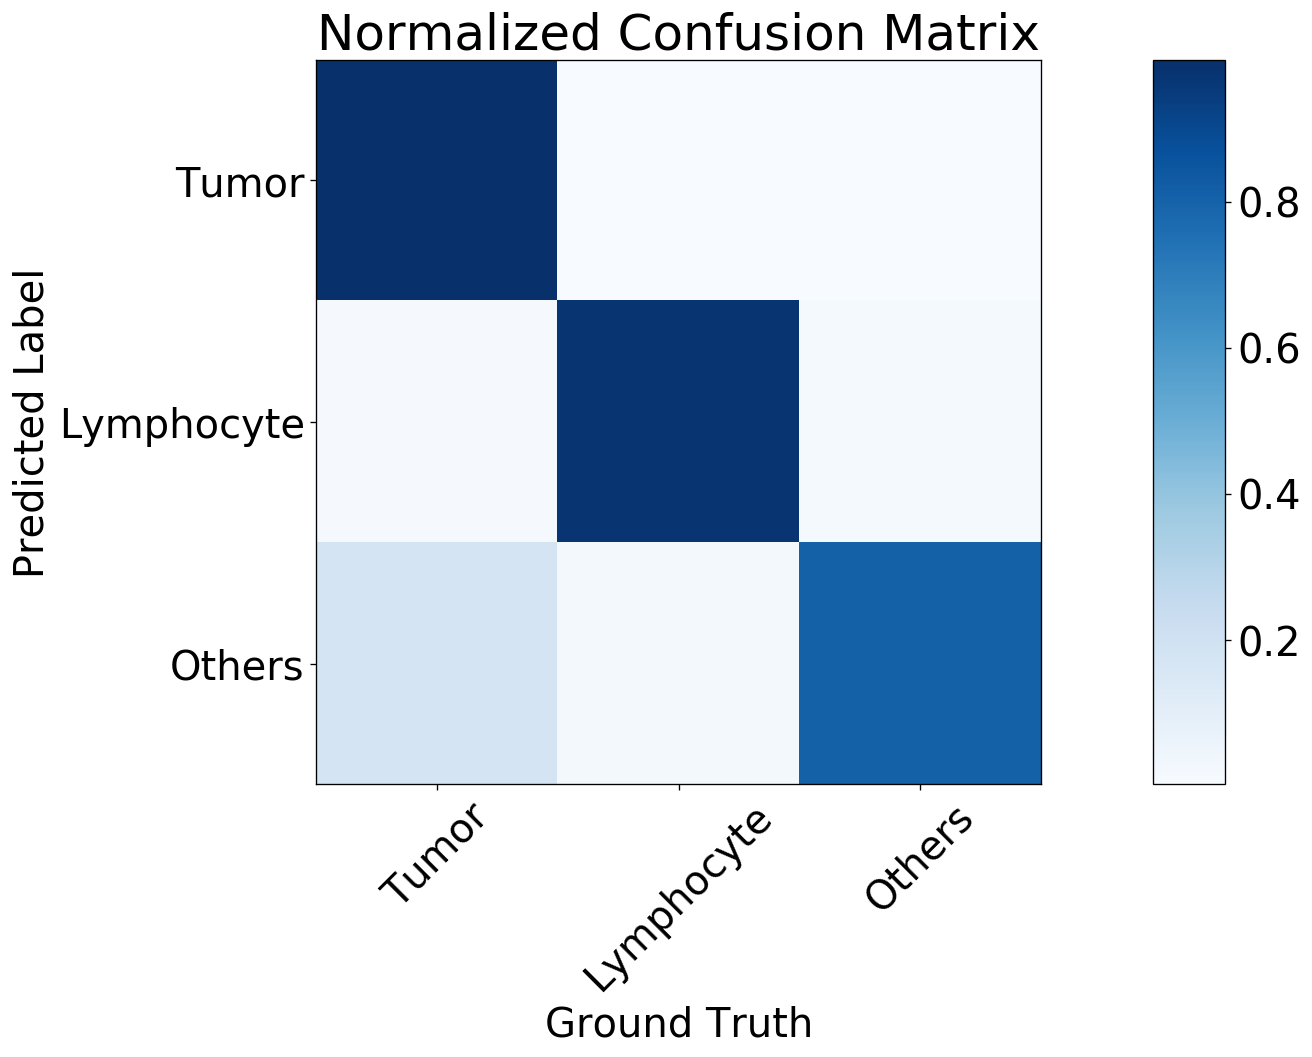

In [93]:
#train 1
cm = confusion_matrix(class_t, class_p)
np.set_printoptions(precision=2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm_normalized)
plt.figure(figsize=(12,8), dpi=120)
labels=["Tumor","Lymphocyte","Others"]
ind_array = np.arange(len(labels))
x, y = np.meshgrid(ind_array, ind_array)

plot_confusion_matrixs(cm_normalized, title='Normalized Confusion Matrix',cmap=plt.cm.Blues)

plot_confusion_matrix(cm_normalized, title='Normalized Confusion Matrix',cmap=plt.cm.Blues)
plt.show()

###### labels=["t","l","o"]
tick_marks = np.array(range(len(labels))) + 0.5
cm=confusion_matrix(class_t,class_p)
print(cm) 
plot_confusion_matrix(cm)
np.set_printoptions(precision=2)
cm_normalized = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
print (cm_normalized)
plt.figure(figsize=(12,8), dpi=120)
ind_array = np.arange(len(labels))
x, y = np.meshgrid(ind_array, ind_array)
for x_val, y_val in zip(x.flatten(), y.flatten()):
    c = cm_normalized[y_val][x_val]
    if (c > 0.01):
        plt.text(x_val, y_val, "%0.2f" %(c,), color='red', fontsize=7, va='center', ha='center')
#offset the tick
plt.gca().set_xticks(tick_marks, minor=True)
plt.gca().set_yticks(tick_marks, minor=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.grid(True, which='minor', linestyle='-')
plt.gcf().subplots_adjust(bottom=0.15)
 
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
#show confusion matrix
plt.show()

In [26]:
import scipy.misc
import matplotlib

dataset_test = NucleiDataset()
dataset_test.load_datasets('tests')
dataset_test.prepare()
image_test_ids = dataset_test.image_ids.tolist()
print(image_test_ids)
cnt=0
for i in range(len(image_test_ids)):
    image_test_id = image_test_ids[i]
    original_image= dataset_test.load_image(image_test_id)
    results = model.detect([original_image], verbose=1)
    r = results[0]
    masks_new,class_ids = merge_masks(r['masks'], r['class_ids'],0.3)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4))
    for i in range(masks_new.shape[2]):
        masks_new[..., i] = cv2.morphologyEx(masks_new[:,:,i].astype(np.uint8), cv2.MORPH_DILATE, kernel).astype(bool)  
    image_annotateds = mark_boundaries(original_image, utilities.mask_to_label(masks_new[:,:,class_ids==1]), color=(1, 0, 0), mode='thick')
    image_annotateds = mark_boundaries(image_annotateds, utilities.mask_to_label(masks_new[:,:,class_ids==2]), color=(0, 1, 0), mode='thick')
    image_annotateds = mark_boundaries(image_annotateds, utilities.mask_to_label(masks_new[:,:,class_ids==3]), color=(0, 0, 1), mode='thick')
    plt.imshow(image_annotateds)  
    folder_path = os.path.join( 'C:\\Users\\Yi\\Documents\\python_projects\\nucleusSeg','conclusion',str(cnt))
    os.makedirs(folder_path, exist_ok=False)
    matplotlib.image.imsave(os.path.join(folder_path, 'image_label.png'), image_annotateds)
    cnt += 1    
    

StopIteration: 

In [ ]:
cnt=0   #C:\Users\Yi\Documents\HCC\1-9\9a2f59a4-604a-43c9-8303-b1c1204754e6\0_Roi  a30652c7-e18c-45f0-9452-cd72bd6130f7

fp='C:\\Users\\Yi\\Documents\\HCC\\12-3\\18e5854a-fa1c-4e68-9941-69e6bf8a7ffb\\1_Roi'
_, f, _ = next(os.walk(fp))
for i in tqdm(f):
    full_path=os.path.join(fp,i)
    image_path=os.path.join(full_path,'image.tiff')
    print(i)
    print(image_path)
    image_test = cv2.imread(image_path)
    image_test = cv2.cvtColor(image_test, cv2.COLOR_BGR2RGB)
    image_test = normalizeStaining(image_test)
    plt.imshow(image_test)
    results = model.detect([image_test], verbose=1)
    r = results[0]
    masks_new,class_ids = merge_masks(r['masks'], r['class_ids'],0.02)
#     masks_new = opening(masks_new, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)))
#     masks_new = non_max_suppressions(r['masks'], r['class_ids'], 0.2)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4))
    for i in range(masks_new.shape[2]):
        masks_new[..., i] = cv2.morphologyEx(masks_new[:,:,i].astype(np.uint8), cv2.MORPH_DILATE, kernel).astype(bool)  
    image_annotateds = mark_boundaries(image_test, utilities.mask_to_label(masks_new[:,:,class_ids==1]), color=(0, 1, 0), mode='thick')
    image_annotateds = mark_boundaries(image_annotateds, utilities.mask_to_label(masks_new[:,:,class_ids==2]), color=(1, 0, 0), mode='thick')
    image_annotateds = mark_boundaries(image_annotateds, utilities.mask_to_label(masks_new[:,:,class_ids==3]), color=(0, 0, 1), mode='thick')
    plt.imshow(image_annotateds)  
#     folder_path = os.path.join( fp,str(cnt))
#     os.makedirs(folder_path, exist_ok=False)
    matplotlib.image.imsave(os.path.join(full_path, 'image_label.png'), image_annotateds)
#     matplotlib.image.imsave(os.path.join(folder_path, 'image_labels.png'), image_annotateds)
    cnt += 1   

In [ ]:
#test_data

dataset_test = NucleiDataset()
dataset_test.load_datasets('tests')
dataset_test.prepare()
image_test_ids = dataset_test.image_ids.tolist()
print(image_test_ids)
cnt=0
for i in range(len(image_test_ids)):
    image_test_id = image_test_ids[i]
    original_image= dataset_test.load_image(image_test_id)
    results = model.detect([original_image], verbose=1)
    r = results[0]
    masks_new,class_ids = merge_masks(r['masks'], r['class_ids'],0.05)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4))
    for i in range(masks_new.shape[2]):
        masks_new[..., i] = cv2.morphologyEx(masks_new[:,:,i].astype(np.uint8), cv2.MORPH_DILATE, kernel).astype(bool)  
    image_annotateds = mark_boundaries(original_image, utilities.mask_to_label(masks_new[:,:,class_ids==1]), color=(1, 0, 0), mode='thick')
    image_annotateds = mark_boundaries(image_annotateds, utilities.mask_to_label(masks_new[:,:,class_ids==2]), color=(0, 1, 0), mode='thick')
    image_annotateds = mark_boundaries(image_annotateds, utilities.mask_to_label(masks_new[:,:,class_ids==3]), color=(0, 0, 1), mode='thick')
    plt.imshow(image_annotateds)  
    folder_path = os.path.join( 'C:\\Users\\Yi\\Documents\\python_projects\\nucleusSeg','conclusion',str(cnt))
    os.makedirs(folder_path, exist_ok=False)
    matplotlib.image.imsave(os.path.join(folder_path, 'image_label.png'), image_annotateds)
    cnt += 1    
    

In [60]:
width=256
height=256

In [ ]:
e_folders='C:\\Users\\Yi\\Documents\\HCCW\\HCC'
_, folders, _ = next(os.walk(e_folders))
print(len(folders))
for folder in folders: 
    _,i_folders,_ = next(os.walk(os.path.join(e_folders, folder)))
    print(i_folders)
    for image_folders in i_folders:
        print(image_folders)
        _, image, _ = next(os.walk(os.path.join(e_folders, folder,image_folders)))
        print(image)
        haiyue=[]
        haiyue1=[]
        for i in range(len(image)):
            if image[i].startswith('A'):
                haiyue1.append(0)
            else:   
                haiyue.append(image[i])
        for hai in haiyue:
            #此处hai相当于test
            full_paths=os.path.join(e_folders,folder,image_folders,hai)
            dataset_test = NucleiDataset()
            dataset_test.load_datasets(full_paths)
            dataset_test.prepare()
            image_test_ids = dataset_test.image_ids.tolist()
#             cnt=0
            for i in range(len(image_test_ids)):
                image_test_id = image_test_ids[i]
                original_image= dataset_test.load_image(image_test_id)
                original_image1= dataset_test.load_image(image_test_id)
                original_image2= dataset_test.load_image(image_test_id)
                original_image3= dataset_test.load_image(image_test_id)
                results = model.detect([original_image], verbose=1)
                r = results[0]
                masks_new,class_ids = merge_masks(r['masks'], r['class_ids'],0.05)
                kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4))
                for i in range(masks_new.shape[2]):
                    masks_new[..., i] = cv2.morphologyEx(masks_new[:,:,i].astype(np.uint8), cv2.MORPH_DILATE, kernel).astype(bool)  
                image_annotateds = mark_boundaries(original_image, utilities.mask_to_label(masks_new[:,:,class_ids==1]), color=(0, 1, 0), mode='thick')
                image_annotateds = mark_boundaries(image_annotateds, utilities.mask_to_label(masks_new[:,:,class_ids==2]), color=(1, 0, 0), mode='thick')
                image_annotateds = mark_boundaries(image_annotateds, utilities.mask_to_label(masks_new[:,:,class_ids==3]), color=(0, 0, 1), mode='thick')
                
                image_annotateds1 = mark_boundaries(original_image1, utilities.mask_to_label(masks_new[:,:,class_ids==1]), color=(0, 1, 0), mode='thick')

                image_annotateds2 = mark_boundaries(original_image2, utilities.mask_to_label(masks_new[:,:,class_ids==2]), color=(1, 0, 0), mode='thick')
                
                image_annotateds3 = mark_boundaries(original_image3, utilities.mask_to_label(masks_new[:,:,class_ids==3]), color=(0, 0, 1), mode='thick')

                plt.imshow(image_annotateds)  
                cnt = dataset_test.image_info[image_test_id]['id']
                full_path=os.path.join(full_paths,cnt)
                print(full_path)
                matplotlib.image.imsave(os.path.join(full_path, 'label.png'), image_annotateds)    
                matplotlib.image.imsave(os.path.join(full_path, 't_label.png'), image_annotateds1)  
                matplotlib.image.imsave(os.path.join(full_path, 'l_label.png'), image_annotateds2)  
                matplotlib.image.imsave(os.path.join(full_path, 'o_label.png'), image_annotateds3)  


In [ ]:
#                 stencil1 = np.zeros(image_test.shape).astype(image_test.dtype)
#                 stencil2 = np.zeros(image_test.shape).astype(image_test.dtype)
#                 stencil3 = np.zeros(image_test.shape).astype(image_test.dtype)
#                 for j1 in range(masks_new.shape[-1]):
#                     if class_ids[j1]==1:
#                         _, contour, _ = cv2.findContours(masks_new[...,j1].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
#                         color = [255, 255, 255]    
#                         cv2.fillPoly(stencil1, contour, color)
#                     if class_ids[j1]==2:
#                         _, contour, _ = cv2.findContours(masks_new[...,j1].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
#                         color = [255, 255, 255]    
#                         cv2.fillPoly(stencil2, contour, color)                    
#                     if class_ids[j1]==3:
#                         _, contour, _ = cv2.findContours(masks_new[...,j1].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
#                         color = [255, 255, 255]    
#                         cv2.fillPoly(stencil3, contour, color)                    
#                     matplotlib.image.imsave(os.path.join(full_paths,'label_t.png'), stencil1)
#                     matplotlib.image.imsave(os.path.join(full_paths,'label_l.png'), stencil2)
#                     matplotlib.image.imsave(os.path.join(full_paths,'label_o.png'),  stencil3)
#                 print("For loop 1: ", time.time()-start_time)
#                 print(full_paths)
#                 matplotlib.image.imsave(os.path.join(full_paths, 'label.png'), image_annotateds)    
 


In [ ]:
#                 folder_path = os.path.join( full_paths,'conclusion',str(cnt))
#                 os.makedirs(folder_path, exist_ok=False)
#                 matplotlib.image.imsave(os.path.join(folder_path,'image_label.png'), image_annotateds)
#                 cnt += 1    
#                 stencil = np.zeros(image_test.shape).astype(image_test.dtype)
                
#                 for j1 in range(masks_new.shape[-1]):
#                     if class_ids[j1]==1:
#                         _, contour, _ = cv2.findContours(masks_new[...,j1].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
#                         color = [255, 255, 255]    
#                         cv2.fillPoly(stencil, contour, color)
#                     matplotlib.image.imsave(os.path.join(full_paths,'label_t.png'), stencil)
#                 print("For loop 1: ", time.time()-start_time)
                
#                 stencil = np.zeros(image_test.shape).astype(image_test.dtype)
#                 for j2 in range(masks_new.shape[-1]):
#                     if class_ids[j2]==2:
#                         _, contour, _ = cv2.findContours(masks_new[...,j2].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
#                         color = [255, 255, 255]    
#                         cv2.fillPoly(stencil, contour, color)
#                     matplotlib.image.imsave(os.path.join(full_paths,'label_l.png'), stencil)
#                 print("For loop 2: ", time.time()-start_time)
                    
#                 stencil = np.zeros(image_test.shape).astype(image_test.dtype)
#                 for jj in range(masks_new.shape[-1]):
#                     if class_ids[jj]==3:
#                         _, contour, _ = cv2.findContours(masks_new[...,jj].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
#                         color = [255, 255, 255]    
#                         cv2.fillPoly(stencil, contour, color)
              
#                     matplotlib.image.imsave(os.path.join(full_paths,'label_o.png'),  stencil)    
                
#                 print(full_paths)
#                 matplotlib.image.imsave(os.path.join(full_paths, 'label.png'), image_annotateds)    
 

            
            
            
            
#             _, images, _ = next(os.walk(os.path.join(e_folders, folder,image_folders,hai)))
#             for i in images:
#                 full_path=os.path.join(e_folders,folder,image_folders,hai,i)
#                 image_path=os.path.join(full_path,'image.png')
#                 image_test = cv2.imread(image_path)
#                 print(image_path)
#                 image_test = cv2.cvtColor(image_test, cv2.COLOR_BGR2RGB)
#                 image_test = normalizeStaining(image_test)
# #                 plt.imshow(image_test)
#                 results = model.detect([image_test], verbose=1)
#                 r = results[0]
#                 masks_new,class_ids = merge_masks(r['masks'], r['class_ids'],0.02)
#                 kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4))
#                 for j in range(masks_new.shape[2]):
#                     masks_new[..., j] = cv2.morphologyEx(masks_new[:,:,j].astype(np.uint8), cv2.MORPH_DILATE, kernel).astype(bool)  
#                 image_annotateds = mark_boundaries(image_test , utilities.mask_to_label(masks_new[:,:,class_ids==1]), color=(0,1, 0), mode='thick')
#                 image_annotateds = mark_boundaries(image_annotateds, utilities.mask_to_label(masks_new[:,:,class_ids==2]), color=(1, 0, 0), mode='thick')
#                 image_annotateds = mark_boundaries(image_annotateds, utilities.mask_to_label(masks_new[:,:,class_ids==3]), color=(0, 0, 1), mode='thick')
#                 plt.imshow(image_annotateds)  
#                 matplotlib.image.imsave(os.path.join(full_path, 'label_t.png'), image_annotateds)


In [18]:
#多进程操作
#图像的path获取
#对于一张图像的操作，获得检测解果

def image_Detect(filename):

    image_path=os.path.join(filename,'image.tiff')
    image_test = cv2.imread(image_path)
#     print(image_path)
    image_test = cv2.cvtColor(image_test, cv2.COLOR_BGR2RGB)
    image_test = normalizeStaining(image_test)
#     print("Dataloading: ", time.time()-start_time)

    results = model.detect([image_test], verbose=1)
#     print("Mask R-CNN: ", time.time()-start_time)
    r = results[0]

    masks_new,class_ids = merge_masks(r['masks'], r['class_ids'],0.05)
#     print("Merge Masks: ", time.time()-start_time)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4))
    for j in range(masks_new.shape[2]):
        masks_new[..., j] = cv2.morphologyEx(masks_new[:,:,j].astype(np.uint8), cv2.MORPH_DILATE, kernel).astype(bool)  
        image_annotateds = mark_boundaries(image_test , utilities.mask_to_label(masks_new[:,:,class_ids==1]), color=(0,1, 0), mode='thick')
        image_annotateds = mark_boundaries(image_annotateds, utilities.mask_to_label(masks_new[:,:,class_ids==2]), color=(1, 0, 0), mode='thick')
        image_annotateds = mark_boundaries(image_annotateds, utilities.mask_to_label(masks_new[:,:,class_ids==3]), color=(0, 0, 1), mode='thick')
    stencil1 = np.zeros(image_test.shape).astype(image_test.dtype)
    stencil2 = np.zeros(image_test.shape).astype(image_test.dtype)
    stencil3 = np.zeros(image_test.shape).astype(image_test.dtype)
    for j1 in range(masks_new.shape[-1]):
        _, contour, _ = cv2.findContours(masks_new[...,j1].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        color = [255, 255, 255]
        if class_ids[j1]==1:  
            cv2.fillPoly(stencil1, contour, color)
        if class_ids[j1]==2:    
            cv2.fillPoly(stencil2, contour, color)                    
        if class_ids[j1]==3:
            cv2.fillPoly(stencil3, contour, color)                    
    matplotlib.image.imsave(os.path.join(filename,'label_t.png'), stencil1)
    matplotlib.image.imsave(os.path.join(filename,'label_l.png'), stencil2)
    matplotlib.image.imsave(os.path.join(filename,'label_o.png'),  stencil3)
#     print("For loop 1: ", time.time()-start_time)
#     print(full_paths)
    matplotlib.image.imsave(os.path.join(filename, 'label.png'), image_annotateds)    

In [ ]:
from multiprocessing import Pool

e_folders='C:\\Users\\Yi\\Documents\\HCCW\\HCC'
_, folders, _ = next(os.walk(e_folders))
print(len(folders))
for folder in folders: 
    _,i_folders,_ = next(os.walk(os.path.join(e_folders, folder)))
    print(i_folders)
    for image_folders in i_folders:
        print(image_folders)
        _, image, _ = next(os.walk(os.path.join(e_folders, folder,image_folders)))
        print(image)
        haiyue=[]
        haiyue1=[]
        for ii in range(len(image)):
            if image[ii].startswith('A'):
                haiyue.append(image[ii])
        for hai in haiyue:
            _, images, _ = next(os.walk(os.path.join(e_folders, folder,image_folders,hai)))
            image_paths=[]
            start = time.time()
            for i in images: 
                full_paths=os.path.join(e_folders,folder,image_folders,hai,i)
                image_paths.append(full_paths)
            print(image_paths)    
            pool = Pool(6)#参数如果为空，表示使用所有核心
            pool.map(image_Detect,image_paths)#map的第二个参数imgs，必须是可迭代的
            pool.close()
            pool.join()
            end = time.time()
            print (end - start)


5
['116056e0-7080-4281-820a-681f82f87e46', '1563880c-95c1-47cb-98dd-c3566adafbe6', '213cda74-5f5d-4325-be39-2d726bb6f4ec', '4d20a0e1-d10d-4679-be59-e7e292e14a11', '5111a997-afae-465c-a38d-e18c59dd03b8', '66af8c41-00c8-4dd7-8c7e-fe5240a4d6e6', '6965cc90-e649-4c7f-9f6b-45e51f7b19b0', '98816a9a-ad3e-4459-bde0-f77827e6d994', 'aaa8a746-c25c-4775-8724-2b54a261ccfc', 'aaafd3e1-84f1-4c9c-82fc-fbae3abfbc6c', 'ae13a461-e15d-4cf4-99a8-b5a146ca8a67', 'ba2b8b6f-7c65-4fa1-9f91-ce55037457d2', 'be340449-5ed3-4ff5-a049-e0dcfea63832', 'ea42ab55-bed2-48bd-a036-8d721ae8ec8f', 'fe78e490-ce1c-4f42-9178-629450ae4ad4']
116056e0-7080-4281-820a-681f82f87e46
['A0_Roi', 'A1_Roi', 'A2_Roi', 'A3_Roi', 'Cc0_CTROI_', 'Cc1_CTROI_', 'Cc2_CTROI_', 'Ii0_IMROI_', 'Ii1_IMROI_', 'ZAa0_ATROi_', 'ZAa1_ATROi_', 'ZAa2_ATROi_', 'ZAa3_ATROi_']
['C:\\Users\\Yi\\Documents\\HCCW\\HCC\\1-7\\116056e0-7080-4281-820a-681f82f87e46\\A0_Roi\\0', 'C:\\Users\\Yi\\Documents\\HCCW\\HCC\\1-7\\116056e0-7080-4281-820a-681f82f87e46\\A0_Roi\\1', 'C

In [ ]:
#         image_paths=[]
#         for hai in haiyue:
#             _, images, _ = next(os.walk(os.path.join(e_folders, folder,image_folders,hai)))
#             for i in images:
#                 start_time = time.time()
#                 full_paths=os.path.join(e_folders,folder,image_folders,hai,i)
#                 image_paths.append(full_paths)
                


In [15]:
from multiprocessing import Pool
image_paths=[]
e_folders='C:\\Users\\Yi\\Documents\\HCCW\\HCC'
_, folders, _ = next(os.walk(e_folders))
print(len(folders))
for folder in folders: 
    _,i_folders,_ = next(os.walk(os.path.join(e_folders, folder)))
    print(i_folders)
    for image_folders in i_folders:
        print(image_folders)
        _, image, _ = next(os.walk(os.path.join(e_folders, folder,image_folders)))
        print(image)
        haiyue=[]
        haiyue1=[]
        for ii in range(len(image)):
            if image[ii].startswith('A'):
                haiyue.append(image[ii])
        for hai in haiyue:
            _, images, _ = next(os.walk(os.path.join(e_folders, folder,image_folders,hai)))
            for i in images: 
                full_paths=os.path.join(e_folders,folder,image_folders,hai,i)
                image_paths.append(full_paths)
print(image_paths)    

1
['4d20a0e1-d10d-4679-be59-e7e292e14a11', '66af8c41-00c8-4dd7-8c7e-fe5240a4d6e6']
4d20a0e1-d10d-4679-be59-e7e292e14a11
['A0_Roi', 'A1_Roi', 'A2_Roi', 'Cc0_CTROI_', 'Cc1_CTROI_', 'Cc2_CTROI_', 'Cc3_CTROI_', 'Cc4_CTROI_', 'zAa0_ATROi_', 'zAa1_ATROi_', 'zAa2_ATROi_']
66af8c41-00c8-4dd7-8c7e-fe5240a4d6e6
['A0_Roi', 'A2_Roi', 'C0_CTROI', 'Cc0_CTROI_', 'Cc1_CTROI_', 'Cc2_CTROI_', 'Cc3_CTROI_', 'Ii0_IMROI_', 'Ii1_IMROI_', 'Ii2_IMROI_', 'ZAa0_ATROi_', 'ZAa2_ATROi_']
['C:\\Users\\Yi\\Documents\\HCCW\\HCC\\1-7\\4d20a0e1-d10d-4679-be59-e7e292e14a11\\A0_Roi\\0', 'C:\\Users\\Yi\\Documents\\HCCW\\HCC\\1-7\\4d20a0e1-d10d-4679-be59-e7e292e14a11\\A0_Roi\\1', 'C:\\Users\\Yi\\Documents\\HCCW\\HCC\\1-7\\4d20a0e1-d10d-4679-be59-e7e292e14a11\\A0_Roi\\10', 'C:\\Users\\Yi\\Documents\\HCCW\\HCC\\1-7\\4d20a0e1-d10d-4679-be59-e7e292e14a11\\A0_Roi\\100', 'C:\\Users\\Yi\\Documents\\HCCW\\HCC\\1-7\\4d20a0e1-d10d-4679-be59-e7e292e14a11\\A0_Roi\\101', 'C:\\Users\\Yi\\Documents\\HCCW\\HCC\\1-7\\4d20a0e1-d10d-4679-be5

In [ ]:
if __name__ == '__main__':
    start = time.time()
    pool = Pool(6)#参数如果为空，表示使用所有核心
    pool.map(image_Detect,image_paths)#map的第二个参数imgs，必须是可迭代的
    pool.close()
    pool.join()
    end = time.time()
    print (end - start)

In [ ]:
from multiprocessing import Pool
def image_Detect(filename):

    image_path=os.path.join(filename,'image.tiff')
    image_test = cv2.imread(image_path)
#     print(image_path)
    image_test = cv2.cvtColor(image_test, cv2.COLOR_BGR2RGB)
    image_test = normalizeStaining(image_test)
#     print("Dataloading: ", time.time()-start_time)

    results = model.detect([image_test], verbose=1)
#     print("Mask R-CNN: ", time.time()-start_time)
    r = results[0]

    masks_new,class_ids = merge_masks(r['masks'], r['class_ids'],0.05)
#     print("Merge Masks: ", time.time()-start_time)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4))
    for j in range(masks_new.shape[2]):
        masks_new[..., j] = cv2.morphologyEx(masks_new[:,:,j].astype(np.uint8), cv2.MORPH_DILATE, kernel).astype(bool)  
        image_annotateds = mark_boundaries(image_test , utilities.mask_to_label(masks_new[:,:,class_ids==1]), color=(0,1, 0), mode='thick')
        image_annotateds = mark_boundaries(image_annotateds, utilities.mask_to_label(masks_new[:,:,class_ids==2]), color=(1, 0, 0), mode='thick')
        image_annotateds = mark_boundaries(image_annotateds, utilities.mask_to_label(masks_new[:,:,class_ids==3]), color=(0, 0, 1), mode='thick')
    stencil1 = np.zeros(image_test.shape).astype(image_test.dtype)
    stencil2 = np.zeros(image_test.shape).astype(image_test.dtype)
    stencil3 = np.zeros(image_test.shape).astype(image_test.dtype)
    for j1 in range(masks_new.shape[-1]):
        _, contour, _ = cv2.findContours(masks_new[...,j1].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        color = [255, 255, 255]
        if class_ids[j1]==1:  
            cv2.fillPoly(stencil1, contour, color)
        if class_ids[j1]==2:    
            cv2.fillPoly(stencil2, contour, color)                    
        if class_ids[j1]==3:
            cv2.fillPoly(stencil3, contour, color)                    
    matplotlib.image.imsave(os.path.join(filename,'label_t.png'), stencil1)
    matplotlib.image.imsave(os.path.join(filename,'label_l.png'), stencil2)
    matplotlib.image.imsave(os.path.join(filename,'label_o.png'),  stencil3)
#     print("For loop 1: ", time.time()-start_time)
#     print(full_paths)
    matplotlib.image.imsave(os.path.join(filename, 'label.png'), image_annotateds)    
    print(filename)

if __name__ == '__main__':
    start = time.time()
    p = Pool(6)
    p.map(image_Detect,image_paths)
    p.close()
    p.join()
    end = time.time()
    print(end - start)
    print('end')


In [16]:
def write_xml_o(masks,class_ids, folder_path):
    with open(os.path.join(folder_path, 'label_s.xml'),'w') as f:
        f.write('<?xml version="1.0" encoding="UTF-8"?>\n');
        f.write('<!-- MIPAV VOI file -->\n');
        f.write('<VOI xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">\n')
        f.write('<Unique-ID>1234567890</Unique-ID>\n')
        f.write('<Curve-type>0</Curve-type>\n')
        f.write('<Color>255,0,255,0</Color>\n')
        f.write('<Thickness>1</Thickness>\n')

        for i in range(masks.shape[-1]):
            _, contours, _ = cv2.findContours(masks[...,i].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            if class_ids[i]==3:
                f.write('<Contour>\n')
                f.write('<Slice-number>0</Slice-number>\n')
                for contour in contours[0]:
                    f.write('<Pt>')
                    f.write(str(float(contour[0,0])))
                    f.write(',')
                    f.write(str(float(contour[0,1])))
                    f.write('</Pt>\n')
                f.write('</Contour>\n')

        f.write('</VOI>')

In [17]:
def write_xml_l(masks,class_ids, folder_path):
    with open(os.path.join(folder_path, 'label_l.xml'),'w') as f:
        f.write('<?xml version="1.0" encoding="UTF-8"?>\n');
        f.write('<!-- MIPAV VOI file -->\n');
        f.write('<VOI xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">\n')
        f.write('<Unique-ID>1234567890</Unique-ID>\n')
        f.write('<Curve-type>0</Curve-type>\n')
        f.write('<Color>255,0,255,0</Color>\n')
        f.write('<Thickness>1</Thickness>\n')

        for i in range(masks.shape[-1]):
            _, contours, _ = cv2.findContours(masks[...,i].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            if class_ids[i]==2:
                f.write('<Contour>\n')
                f.write('<Slice-number>0</Slice-number>\n')
                for contour in contours[0]:
                    f.write('<Pt>')
                    f.write(str(float(contour[0,0])))
                    f.write(',')
                    f.write(str(float(contour[0,1])))
                    f.write('</Pt>\n')
                f.write('</Contour>\n')

        f.write('</VOI>')

In [18]:
def write_xml_t(masks,class_ids, folder_path):
    with open(os.path.join(folder_path, 'label_t.xml'),'w') as f:
        f.write('<?xml version="1.0" encoding="UTF-8"?>\n');
        f.write('<!-- MIPAV VOI file -->\n');
        f.write('<VOI xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">\n')
        f.write('<Unique-ID>1234567890</Unique-ID>\n')
        f.write('<Curve-type>0</Curve-type>\n')
        f.write('<Color>255,0,255,0</Color>\n')
        f.write('<Thickness>1</Thickness>\n')

        for i in range(masks.shape[-1]):
            _, contours, _ = cv2.findContours(masks[...,i].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            if class_ids[i]==1:
                f.write('<Contour>\n')
                f.write('<Slice-number>0</Slice-number>\n')
                for contour in contours[0]:
                    f.write('<Pt>')
                    f.write(str(float(contour[0,0])))
                    f.write(',')
                    f.write(str(float(contour[0,1])))
                    f.write('</Pt>\n')
                f.write('</Contour>\n')

        f.write('</VOI>')

In [ ]:
import time

e_folders='E:\haha'
_, folders, _ = next(os.walk(e_folders))
print(len(folders))
for folder in folders: 
    _,i_folders,_ = next(os.walk(os.path.join(e_folders, folder)))
    print(i_folders)
    for image_folders in i_folders:
        print(image_folders)
        _, image, _ = next(os.walk(os.path.join(e_folders, folder,image_folders)))
        print(image)
        haiyue=[]
        haiyue1=[]
        for i in range(len(image)):
            if image[i].startswith('A'):
                haiyue1.append(0)
            else:   
                haiyue.append(image[i])
        for hai in haiyue:
            _, images, _ = next(os.walk(os.path.join(e_folders, folder,image_folders,hai)))
            for i in images:
                start_times = time.time()
#                 start_time = time.time()
                full_paths=os.path.join(e_folders,folder,image_folders,hai,i)
                image_path=os.path.join(full_paths,'image.tiff')
                image_test = cv2.imread(image_path)
                print(image_path)
                image_test = cv2.cvtColor(image_test, cv2.COLOR_BGR2RGB)
                image_test = normalizeStaining(image_test)
                start_time = time.time()
                results = model.detect([image_test], verbose=1)
                print("Mask R-CNN: ", time.time()-start_time)
                r = results[0]
                start_time = time.time()
                masks_new,class_ids = merge_masks(r['masks'], r['class_ids'],0.05)
                print("Merge Masks: ", time.time()-start_time)
                kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4))
                start_time = time.time()
                for j in range(masks_new.shape[2]):
                    masks_new[..., j] = cv2.morphologyEx(masks_new[:,:,j].astype(np.uint8), cv2.MORPH_DILATE, kernel).astype(bool)  
                image_annotateds = mark_boundaries(image_test , utilities.mask_to_label(masks_new[:,:,class_ids==1]), color=(0,1, 0), mode='thick')
                image_annotateds = mark_boundaries(image_annotateds, utilities.mask_to_label(masks_new[:,:,class_ids==2]), color=(1, 0, 0), mode='thick')
                image_annotateds = mark_boundaries(image_annotateds, utilities.mask_to_label(masks_new[:,:,class_ids==3]), color=(0, 0, 1), mode='thick')
                if 1 in class_ids:
                    write_xml_t(masks_new,class_ids, full_paths)
                if 2 in class_ids:
                    write_xml_l(masks_new,class_ids, full_paths)   
                if 3 in class_ids:
                    write_xml_o(masks_new,class_ids, full_paths)    
                    
                matplotlib.image.imsave(os.path.join(full_paths, 'label.png'), image_annotateds) 
                print("For loop 1: ", time.time()-start_time)
                end = time.time()
                print("imgae",end-start_times)
                 
                


In [35]:
e_folders='E:\\HCC\\hahaa'
_, folders, _ = next(os.walk(e_folders))
print(len(folders))
for folder in folders: 
    _,i_folders,_ = next(os.walk(os.path.join(e_folders, folder)))
    print(i_folders)
    for image_folders in i_folders:
        print(image_folders)
        _, image, _ = next(os.walk(os.path.join(e_folders, folder,image_folders)))
        print(image)
        for hai in image:
            #此处hai相当于test
            full_paths=os.path.join(e_folders,folder,image_folders,hai)
            dataset_test = NucleiDataset()
            dataset_test.load_datasets(full_paths)
            dataset_test.prepare()
            image_test_ids = dataset_test.image_ids.tolist()
            
            for i in range(len(image_test_ids)):
                start_times = time.time()
                image_test_id = image_test_ids[i]
                original_image= dataset_test.load_image(image_test_id)
                a=original_image.shape
                height=a[0]
                width=a[1]
                start_time = time.time()
                results = model.detect([original_image], verbose=1)
                print("Mask R-CNN: ", time.time()-start_time)
                r = results[0]
                start_time = time.time()
                masks_new,class_ids = merge_masks(r['masks'], r['class_ids'],0.05)
                print("Merge Masks: ", time.time()-start_time)
                kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4))
                start_time = time.time()
                for j in range(masks_new.shape[2]):
                    masks_new[..., j] = cv2.morphologyEx(masks_new[:,:,j].astype(np.uint8), cv2.MORPH_DILATE, kernel).astype(bool)  
                image_annotateds = mark_boundaries(original_image, utilities.mask_to_label(masks_new[:,:,class_ids==1]), color=(0, 1, 0), mode='thick')
                image_annotateds = mark_boundaries(image_annotateds, utilities.mask_to_label(masks_new[:,:,class_ids==2]), color=(1, 0, 0), mode='thick')
                image_annotateds = mark_boundaries(image_annotateds, utilities.mask_to_label(masks_new[:,:,class_ids==3]), color=(0, 0, 1), mode='thick')
               
                cnt = dataset_test.image_info[image_test_id]['id']
                full_path=os.path.join(full_paths,cnt)
                print(full_path)
                if 1 in class_ids:
                    write_xml_t(masks_new,class_ids, full_path)
                if 2 in class_ids:
                    write_xml_l(masks_new,class_ids, full_path)   
                if 3 in class_ids:
                    write_xml_o(masks_new,class_ids, full_path)    
                    
                matplotlib.image.imsave(os.path.join(full_path, 'label.png'), image_annotateds) 
                print("For loop 1: ", time.time()-start_time)
                end = time.time()
                print("imgae",end-start_times)
              
  
 
                


2
['bc9e5af5-293f-402c-9d29-883f711bf672', 'd36b150a-b813-4bd3-a043-f9bca6164001']
bc9e5af5-293f-402c-9d29-883f711bf672
['Cc0_CTROI_', 'Ii1_IMROI_']
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\0\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:    0.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max: -131.28277  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.4263744354248047
Merge Masks:  0.0
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\0
For loop 1:  0.20046305656433105
imgae 0.6504387855529785
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\1\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8


Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:    0.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max: -131.28277  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.3808169364929199
Merge Masks:  0.031282901763916016
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\12
For loop 1:  0.2361774444580078
imgae 0.7083673477172852
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\120\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -152.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors             

molded_images            shape: (1, 1024, 1024, 3)    min: -156.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.907742500305176
Merge Masks:  10.968684196472168
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\141
For loop 1:  3.8406190872192383
imgae 18.79440927505493
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\142\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  4.444030523300171
Merge Mask

anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  2.214524984359741
Merge Masks:  5.566864967346191
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\163
For loop 1:  2.3432037830352783
imgae 10.160487413406372
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\164\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -163.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.0617868900299072
Merge Masks:  8.388670206069946
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\164
For loop 1:  3.660452365875244
imgae 15.157765626907349
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d

E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\185
For loop 1:  5.568526029586792
imgae 25.67589235305786
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\186\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -165.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.733502149581909
Merge Masks:  11.809727907180786
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\186
For loop 1:  5.124781847000122
imgae 20.76170253753662
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\187\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded

image                    shape: (1024, 1024, 3)       min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  4.5302369594573975
Merge Masks:  15.389042139053345
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\207
For loop 1:  5.7955169677734375
imgae 25.792845010757446
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\208\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -165.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 25804

image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  4.483378171920776
Merge Masks:  15.200093746185303
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\229
For loop 1:  5.545570135116577
imgae 25.30709457397461
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\23\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  4.074664354324341
Merge Masks:  13.68828272819519
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\23
For lo

Mask R-CNN:  2.135896682739258
Merge Masks:  5.3893609046936035
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\250
For loop 1:  2.2182304859161377
imgae 9.837213516235352
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\251\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:    0.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max: -131.28277  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.37491345405578613
Merge Masks:  0.015624523162841797
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\251
For loop 1:  0.18746185302734375
imgae 0.6404781341552734
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\252\image.tiff
Processing 1 images
image                    sha

E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\273\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:    0.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max: -131.28277  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.3748612403869629
Merge Masks:  0.0
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\273
For loop 1:  0.2030797004699707
imgae 0.5935642719268799
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\274\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)         

molded_images            shape: (1, 1024, 1024, 3)    min: -156.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.783686637878418
Merge Masks:  11.899926662445068
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\295
For loop 1:  4.37600302696228
imgae 20.151017665863037
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\296\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.4498603343963623
Merge Mask

Mask R-CNN:  4.085409641265869
Merge Masks:  13.617460250854492
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\316
For loop 1:  4.476701974868774
imgae 22.26827645301819
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\317\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -156.37516  max:  122.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  4.359760046005249
Merge Masks:  14.191323280334473
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\317
For loop 1:  4.750760555267334
imgae 23.383573532104492
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\318\image.tiff
Processing 1 images
image                    shape: (10

image                    shape: (1024, 1024, 3)       min:    0.00000  max:    0.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max: -131.28277  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.35700392723083496
Merge Masks:  0.02102375030517578
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\339
For loop 1:  0.19339704513549805
imgae 0.6260673999786377
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\34\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:    0.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max: -131.28277  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258

anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  4.438798904418945
Merge Masks:  15.3238205909729
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\37
For loop 1:  5.1921045780181885
imgae 25.03253412246704
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\38\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -171.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  4.55641508102417
Merge Masks:  15.28700876235962
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\38
For loop 1:  4.695105314254761
imgae 24.62067675590515
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f7

E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\6\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:    0.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max: -131.28277  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.3905317783355713
Merge Masks:  0.04686760902404785
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\6
For loop 1:  0.2030787467956543
imgae 0.7029671669006348
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\60\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 1

molded_images            shape: (1, 1024, 1024, 3)    min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.8740928173065186
Merge Masks:  12.327733993530273
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\81
For loop 1:  4.261804580688477
imgae 20.54174304008484
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Cc0_CTROI_\82\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -156.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.957261085510254
Merge Masks:

anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.7647922039031982
Merge Masks:  10.91973328590393
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Ii1_IMROI_\101
For loop 1:  4.532342195510864
imgae 19.29489755630493
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Ii1_IMROI_\102\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -155.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.9209442138671875
Merge Masks:  10.517879724502563
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Ii1_IMROI_\102
For loop 1:  4.186516523361206
imgae 18.70345950126648
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d2

E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Ii1_IMROI_\124\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:    0.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max: -131.28277  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.3749113082885742
Merge Masks:  0.0
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Ii1_IMROI_\124
For loop 1:  0.18750405311584473
imgae 0.5936119556427002
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Ii1_IMROI_\125\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:    0.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max: -131.28277  float64
image_metas              shape: (1, 16)        

image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.3627924919128418
Merge Masks:  0.0
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Ii1_IMROI_\20
For loop 1:  0.18746042251586914
imgae 0.5808367729187012
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Ii1_IMROI_\21\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:    0.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max: -131.28277  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.41884326934814453
Merge Masks:  0.0
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Ii1_IMROI_\21
For loop 1:  0.183395147323608

imgae 0.6560955047607422
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Ii1_IMROI_\43\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:    0.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max: -131.28277  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.3749504089355469
Merge Masks:  0.0
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Ii1_IMROI_\43
For loop 1:  0.20308470726013184
imgae 0.593616247177124
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Ii1_IMROI_\44\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:    0.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max: -131.28277  float64
image_metas              s

molded_images            shape: (1, 1024, 1024, 3)    min: -157.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.095586061477661
Merge Masks:  8.564176797866821
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Ii1_IMROI_\65
For loop 1:  3.546030282974243
imgae 15.283864736557007
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Ii1_IMROI_\66\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -159.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.280423641204834
Merge Masks: 

anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  4.2802934646606445
Merge Masks:  13.639994144439697
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Ii1_IMROI_\87
For loop 1:  5.748607397079468
imgae 23.731334447860718
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Ii1_IMROI_\88\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -155.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.7516987323760986
Merge Masks:  10.99985671043396
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-883f711bf672\Ii1_IMROI_\88
For loop 1:  4.35835862159729
imgae 19.18806529045105
E:\HCC\hahaa\12-58\bc9e5af5-293f-402c-9d29-8

E:\HCC\hahaa\12-58\d36b150a-b813-4bd3-a043-f9bca6164001\Aa0_ATROI_\185
For loop 1:  3.7204370498657227
imgae 17.37902545928955
E:\HCC\hahaa\12-58\d36b150a-b813-4bd3-a043-f9bca6164001\Aa0_ATROI_\186\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -162.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  5.030117511749268
Merge Masks:  16.154855251312256
E:\HCC\hahaa\12-58\d36b150a-b813-4bd3-a043-f9bca6164001\Aa0_ATROI_\186
For loop 1:  6.29661750793457
imgae 27.559643745422363
E:\HCC\hahaa\12-58\d36b150a-b813-4bd3-a043-f9bca6164001\Aa0_ATROI_\187\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molde

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -170.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  6.3916096687316895
Merge Masks:  21.96101403236389
E:\HCC\hahaa\12-58\d36b150a-b813-4bd3-a043-f9bca6164001\Aa0_ATROI_\210
For loop 1:  7.77315092086792
imgae 36.25072145462036
E:\HCC\hahaa\12-58\d36b150a-b813-4bd3-a043-f9bca6164001\Aa0_ATROI_\211\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4

image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.3749065399169922
Merge Masks:  0.031247854232788086
E:\HCC\hahaa\12-58\d36b150a-b813-4bd3-a043-f9bca6164001\Aa0_ATROI_\234
For loop 1:  0.18745923042297363
imgae 0.6248500347137451
E:\HCC\hahaa\12-58\d36b150a-b813-4bd3-a043-f9bca6164001\Aa0_ATROI_\235\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:    0.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max: -131.28277  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.3904893398284912
Merge Masks:  0.0
E:\HCC\hahaa\12-58\d36b150a-b813-4bd3-a043-f9bca6164001\Aa0_ATROI_\235
For loop 1:

imgae 21.78138566017151
E:\HCC\hahaa\12-58\d36b150a-b813-4bd3-a043-f9bca6164001\Cc0_CTROI_\113\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  5.251237392425537
Merge Masks:  17.029797554016113
E:\HCC\hahaa\12-58\d36b150a-b813-4bd3-a043-f9bca6164001\Cc0_CTROI_\113
For loop 1:  6.610057353973389
imgae 29.00044536590576
E:\HCC\hahaa\12-58\d36b150a-b813-4bd3-a043-f9bca6164001\Cc0_CTROI_\114\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -166.37516  max:  123.71723  float64
image_metas 

molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max: -131.28277  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.37491416931152344
Merge Masks:  0.0
E:\HCC\hahaa\12-58\d36b150a-b813-4bd3-a043-f9bca6164001\Cc0_CTROI_\135
For loop 1:  0.18746209144592285
imgae 0.5936174392700195
E:\HCC\hahaa\12-58\d36b150a-b813-4bd3-a043-f9bca6164001\Cc0_CTROI_\136\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.5155127048492432
Merge Masks:  0.3124

anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  5.342502117156982
Merge Masks:  15.781115770339966
E:\HCC\hahaa\12-58\d36b150a-b813-4bd3-a043-f9bca6164001\Cc0_CTROI_\17
For loop 1:  6.556248426437378
imgae 27.773518085479736
E:\HCC\hahaa\12-58\d36b150a-b813-4bd3-a043-f9bca6164001\Cc0_CTROI_\18\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -169.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  5.397499084472656
Merge Masks:  17.56265091896057
E:\HCC\hahaa\12-58\d36b150a-b813-4bd3-a043-f9bca6164001\Cc0_CTROI_\18
For loop 1:  6.801868677139282
imgae 29.855740785598755
E:\HCC\hahaa\12-58\d36b150a-b813-4bd3-a043-f

E:\HCC\hahaa\12-58\d36b150a-b813-4bd3-a043-f9bca6164001\Cc0_CTROI_\4\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.6285693645477295
Merge Masks:  10.419380187988281
E:\HCC\hahaa\12-58\d36b150a-b813-4bd3-a043-f9bca6164001\Cc0_CTROI_\4
For loop 1:  4.483328819274902
imgae 18.62500834465027
E:\HCC\hahaa\12-58\d36b150a-b813-4bd3-a043-f9bca6164001\Cc0_CTROI_\40\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16) 

molded_images            shape: (1, 1024, 1024, 3)    min: -165.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.5929088592529297
Merge Masks:  10.393889427185059
E:\HCC\hahaa\12-58\d36b150a-b813-4bd3-a043-f9bca6164001\Cc0_CTROI_\61
For loop 1:  4.077164649963379
imgae 18.12644052505493
E:\HCC\hahaa\12-58\d36b150a-b813-4bd3-a043-f9bca6164001\Cc0_CTROI_\62\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -167.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.577249765396118
Merge Masks:

anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.3905823230743408
Merge Masks:  0.07810282707214355
E:\HCC\hahaa\12-58\d36b150a-b813-4bd3-a043-f9bca6164001\Cc0_CTROI_\83
For loop 1:  0.2499377727508545
imgae 0.8123140335083008
E:\HCC\hahaa\12-58\d36b150a-b813-4bd3-a043-f9bca6164001\Cc0_CTROI_\84\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:    0.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max: -131.28277  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.3904917240142822
Merge Masks:  0.0
E:\HCC\hahaa\12-58\d36b150a-b813-4bd3-a043-f9bca6164001\Cc0_CTROI_\84
For loop 1:  0.1874558925628662
imgae 0.5935707092285156
E:\HCC\hahaa\12-58\d36b150a-b813-4bd3-a043-f9bca61640

E:\HCC\hahaa\12-58\d36b150a-b813-4bd3-a043-f9bca6164001\Ii2_IMROI_\15\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.6560962200164795
Merge Masks:  0.7029681205749512
E:\HCC\hahaa\12-58\d36b150a-b813-4bd3-a043-f9bca6164001\Ii2_IMROI_\15
For loop 1:  0.9216609001159668
imgae 2.3431973457336426
E:\HCC\hahaa\12-58\d36b150a-b813-4bd3-a043-f9bca6164001\Ii2_IMROI_\16\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 

molded_images            shape: (1, 1024, 1024, 3)    min: -168.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.673536777496338
Merge Masks:  10.328279256820679
E:\HCC\hahaa\12-58\d36b150a-b813-4bd3-a043-f9bca6164001\Ii2_IMROI_\37
For loop 1:  4.337905645370483
imgae 18.402207612991333
E:\HCC\hahaa\12-58\d36b150a-b813-4bd3-a043-f9bca6164001\Ii2_IMROI_\38\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.5512821674346924
Merge Masks

image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.374908447265625
Merge Masks:  0.0
E:\HCC\hahaa\142\fcfe68f4-5e27-4ff0-ad91-450e6fd4a047\Aa1_ATROI_\178
For loop 1:  0.17183828353881836
imgae 0.593658447265625
E:\HCC\hahaa\142\fcfe68f4-5e27-4ff0-ad91-450e6fd4a047\Aa1_ATROI_\179\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:    0.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max: -131.28277  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.3748598098754883
Merge Masks:  0.0
E:\HCC\hahaa\142\fcfe68f4-5e27-4ff0-ad91-450e6fd4a047\Aa1_ATROI_\179
For loop 1:  0.1875007152557373
imga

E:\HCC\hahaa\142\fcfe68f4-5e27-4ff0-ad91-450e6fd4a047\Aa1_ATROI_\202\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  6.892777442932129
Merge Masks:  22.717816829681396
E:\HCC\hahaa\142\fcfe68f4-5e27-4ff0-ad91-450e6fd4a047\Aa1_ATROI_\202
For loop 1:  8.359994411468506
imgae 38.033074378967285
E:\HCC\hahaa\142\fcfe68f4-5e27-4ff0-ad91-450e6fd4a047\Aa1_ATROI_\203\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)  

anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  4.233332633972168
Merge Masks:  13.59249234199524
E:\HCC\hahaa\142\fcfe68f4-5e27-4ff0-ad91-450e6fd4a047\Aa1_ATROI_\64
For loop 1:  5.516682863235474
imgae 23.420616626739502
E:\HCC\hahaa\142\fcfe68f4-5e27-4ff0-ad91-450e6fd4a047\Aa1_ATROI_\65\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -163.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  4.1708972454071045
Merge Masks:  13.455946445465088
E:\HCC\hahaa\142\fcfe68f4-5e27-4ff0-ad91-450e6fd4a047\Aa1_ATROI_\65
For loop 1:  5.217572450637817
imgae 22.93815302848816
E:\HCC\hahaa\142\fcfe68f4-5e27-4ff0-ad91-450e6fd4a

E:\HCC\hahaa\142\fcfe68f4-5e27-4ff0-ad91-450e6fd4a047\Aa1_ATROI_\89\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.4998817443847656
Merge Masks:  0.21870708465576172
E:\HCC\hahaa\142\fcfe68f4-5e27-4ff0-ad91-450e6fd4a047\Aa1_ATROI_\89
For loop 1:  0.4842512607574463
imgae 1.2809412479400635
E:\HCC\hahaa\142\fcfe68f4-5e27-4ff0-ad91-450e6fd4a047\Aa1_ATROI_\90\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:    0.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max: -131.28277  float64
image_metas              shape: (1, 16)  

anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.617330551147461
Merge Masks:  9.613300800323486
E:\HCC\hahaa\142\fcfe68f4-5e27-4ff0-ad91-450e6fd4a047\Cc0_CTROI_\19
For loop 1:  3.8576877117156982
imgae 17.127214431762695
E:\HCC\hahaa\142\fcfe68f4-5e27-4ff0-ad91-450e6fd4a047\Cc0_CTROI_\2\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  4.093244552612305
Merge Masks:  12.60929250717163
E:\HCC\hahaa\142\fcfe68f4-5e27-4ff0-ad91-450e6fd4a047\Cc0_CTROI_\2
For loop 1:  5.081417798995972
imgae 21.86274242401123
E:\HCC\hahaa\142\fcfe68f4-5e27-4ff0-ad91-450e6fd4a047

E:\HCC\hahaa\142\fcfe68f4-5e27-4ff0-ad91-450e6fd4a047\Cc0_CTROI_\41\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.2383437156677246
Merge Masks:  8.35666012763977
E:\HCC\hahaa\142\fcfe68f4-5e27-4ff0-ad91-450e6fd4a047\Cc0_CTROI_\41
For loop 1:  3.2054295539855957
imgae 14.883216142654419
E:\HCC\hahaa\142\fcfe68f4-5e27-4ff0-ad91-450e6fd4a047\Cc0_CTROI_\42\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:    0.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max: -131.28277  float64
image_metas              shape: (1, 16)     

anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  4.772244453430176
Merge Masks:  15.5115327835083
E:\HCC\hahaa\142\fcfe68f4-5e27-4ff0-ad91-450e6fd4a047\Cc0_CTROI_\63
For loop 1:  5.8892576694488525
imgae 26.24484157562256
E:\HCC\hahaa\142\fcfe68f4-5e27-4ff0-ad91-450e6fd4a047\Cc0_CTROI_\64\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -165.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  4.595717191696167
Merge Masks:  15.422771453857422
E:\HCC\hahaa\142\fcfe68f4-5e27-4ff0-ad91-450e6fd4a047\Cc0_CTROI_\64
For loop 1:  5.905214071273804
imgae 26.02044105529785
E:\HCC\hahaa\142\fcfe68f4-5e27-4ff0-ad91-450e6fd4a04

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -160.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  6.140585899353027
Merge Masks:  20.660768270492554
E:\HCC\hahaa\142\fcfe68f4-5e27-4ff0-ad91-450e6fd4a047\Cc0_CTROI_\86
For loop 1:  7.830067873001099
imgae 34.72018313407898
E:\HCC\hahaa\142\fcfe68f4-5e27-4ff0-ad91-450e6fd4a047\Cc0_CTROI_\87\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -161.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape

image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.536548376083374
Merge Masks:  9.61629343032837
E:\HCC\hahaa\142\fcfe68f4-5e27-4ff0-ad91-450e6fd4a047\Ii1_IMROI_\17
For loop 1:  4.086076736450195
imgae 17.318702697753906
E:\HCC\hahaa\142\fcfe68f4-5e27-4ff0-ad91-450e6fd4a047\Ii1_IMROI_\18\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.9255270957946777
Merge Masks:  1.494006872177124
E:\HCC\hahaa\142\fcfe68f4-5e27-4ff0-ad91-450e6fd4a047\Ii1_IMROI_\18
For loop 1:  

imgae 23.440338850021362
E:\HCC\hahaa\142\fcfe68f4-5e27-4ff0-ad91-450e6fd4a047\Ii1_IMROI_\8\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.5544981956481934
Merge Masks:  9.126601457595825
E:\HCC\hahaa\142\fcfe68f4-5e27-4ff0-ad91-450e6fd4a047\Ii1_IMROI_\8
For loop 1:  3.584420680999756
imgae 16.344308137893677
E:\HCC\hahaa\142\fcfe68f4-5e27-4ff0-ad91-450e6fd4a047\Ii1_IMROI_\9\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:    0.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max: -131.28277  float64
image_metas           

molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max: -131.28277  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.3779885768890381
Merge Masks:  0.0
E:\HCC\hahaa\142\fe040c77-cb9a-4b2a-899c-199ce8d875dc\Aa2_ATROI_\122
For loop 1:  0.19148898124694824
imgae 0.5924150943756104
E:\HCC\hahaa\142\fe040c77-cb9a-4b2a-899c-199ce8d875dc\Aa2_ATROI_\123\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:    0.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max: -131.28277  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.3779869079589844
Merge Masks:  0.0
E:\HCC\

E:\HCC\hahaa\142\fe040c77-cb9a-4b2a-899c-199ce8d875dc\Aa2_ATROI_\263
For loop 1:  0.19547605514526367
imgae 0.6113631725311279
E:\HCC\hahaa\142\fe040c77-cb9a-4b2a-899c-199ce8d875dc\Aa2_ATROI_\264\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.2882120609283447
Merge Masks:  8.378601789474487
E:\HCC\hahaa\142\fe040c77-cb9a-4b2a-899c-199ce8d875dc\Aa2_ATROI_\264
For loop 1:  3.1465885639190674
imgae 14.852299213409424
E:\HCC\hahaa\142\fe040c77-cb9a-4b2a-899c-199ce8d875dc\Aa2_ATROI_\265\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_im

molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max: -131.28277  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.37599611282348633
Merge Masks:  0.0
E:\HCC\hahaa\142\fe040c77-cb9a-4b2a-899c-199ce8d875dc\Aa2_ATROI_\308
For loop 1:  0.1904902458190918
imgae 0.5884268283843994
E:\HCC\hahaa\142\fe040c77-cb9a-4b2a-899c-199ce8d875dc\Aa2_ATROI_\309\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:    0.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max: -131.28277  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.3809828758239746
Merge Masks:  0.0
E:\HCC\

For loop 1:  6.980339765548706
imgae 31.429980278015137
E:\HCC\hahaa\142\fe040c77-cb9a-4b2a-899c-199ce8d875dc\Cc3_CTROI_\2\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  242.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:   69.62484  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.3929483890533447
Merge Masks:  0.06682348251342773
E:\HCC\hahaa\142\fe040c77-cb9a-4b2a-899c-199ce8d875dc\Cc3_CTROI_\2
For loop 1:  0.21043753623962402
imgae 0.7529871463775635
E:\HCC\hahaa\142\fe040c77-cb9a-4b2a-899c-199ce8d875dc\Cc3_CTROI_\20\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -170.37516  max:  123.7

image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.3779921531677246
Merge Masks:  0.010970592498779297
E:\HCC\hahaa\142\fe040c77-cb9a-4b2a-899c-199ce8d875dc\Cc3_CTROI_\41
For loop 1:  0.19447994232177734
imgae 0.6193466186523438
E:\HCC\hahaa\142\fe040c77-cb9a-4b2a-899c-199ce8d875dc\Cc3_CTROI_\42\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  114.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  1.4092304706573486
Merge Masks:  2.794532537460327
E:\HCC\hahaa\142\fe040c77-cb9a-4b2a-899c-199ce8d875dc\Cc3_CTROI_\42
For lo

imgae 0.7948770523071289
E:\HCC\hahaa\142\fe040c77-cb9a-4b2a-899c-199ce8d875dc\Ii1_IMROI_\13\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  237.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:   65.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.40392231941223145
Merge Masks:  0.03191494941711426
E:\HCC\hahaa\142\fe040c77-cb9a-4b2a-899c-199ce8d875dc\Ii1_IMROI_\13
For loop 1:  0.2792525291442871
imgae 0.7370283603668213
E:\HCC\hahaa\142\fe040c77-cb9a-4b2a-899c-199ce8d875dc\Ii1_IMROI_\14\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  116.71723  float64
image_metas    

image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.38198041915893555
Merge Masks:  0.06382966041564941
E:\HCC\hahaa\142\fe040c77-cb9a-4b2a-899c-199ce8d875dc\Ii1_IMROI_\35
For loop 1:  0.2014613151550293
imgae 0.7350363731384277
E:\HCC\hahaa\142\fe040c77-cb9a-4b2a-899c-199ce8d875dc\Ii1_IMROI_\36\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:    0.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max: -131.28277  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.375993013381958
Merge Masks:  0.0009970664978027344
E:\HCC\hahaa\142\fe040c77-cb9a-4b2a-899c-199ce8d875dc\Ii1_IMROI_\36
For 

E:\HCC\hahaa\142\fe040c77-cb9a-4b2a-899c-199ce8d875dc\Ii1_IMROI_\57
For loop 1:  8.718694686889648
imgae 39.25805425643921
E:\HCC\hahaa\142\fe040c77-cb9a-4b2a-899c-199ce8d875dc\Ii1_IMROI_\58\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  107.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  1.1289808750152588
Merge Masks:  2.0305745601654053
E:\HCC\hahaa\142\fe040c77-cb9a-4b2a-899c-199ce8d875dc\Ii1_IMROI_\58
For loop 1:  1.3005225658416748
imgae 4.561805009841919
E:\HCC\hahaa\142\fe040c77-cb9a-4b2a-899c-199ce8d875dc\Ii1_IMROI_\59\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:    0.00000  uint8
molded_images   

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -162.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  7.126947402954102
Merge Masks:  23.814340591430664
E:\HCC\hahaa\142\fe040c77-cb9a-4b2a-899c-199ce8d875dc\Ii1_IMROI_\69
For loop 1:  8.862309217453003
imgae 39.91529726982117
E:\HCC\hahaa\142\fe040c77-cb9a-4b2a-899c-199ce8d875dc\Ii1_IMROI_\7\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:    0.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max: -131.28277  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape:

anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  1.4451384544372559
Merge Masks:  3.014940023422241
E:\HCC\hahaa\142\fe040c77-cb9a-4b2a-899c-199ce8d875dc\Ii1_IMROI_\90
For loop 1:  1.5598304271697998
imgae 6.109667778015137
E:\HCC\hahaa\142\fe040c77-cb9a-4b2a-899c-199ce8d875dc\Ii1_IMROI_\91\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  6.624291658401489
Merge Masks:  22.21162462234497
E:\HCC\hahaa\142\fe040c77-cb9a-4b2a-899c-199ce8d875dc\Ii1_IMROI_\91
For loop 1:  8.50127649307251
imgae 37.38705563545227
E:\HCC\hahaa\142\fe040c77-cb9a-4b2a-899c-199ce8d875d

In [36]:
e_folders='C:\\Users\\Yi\\Documents'
_, folders, _ = next(os.walk(e_folders))
print(len(folders))
for folder in folders: 
    _,i_folders,_ = next(os.walk(os.path.join(e_folders, folder)))
    print(i_folders)
    for image_folders in i_folders:
        print(image_folders)
        _, image, _ = next(os.walk(os.path.join(e_folders, folder,image_folders)))
        print(image)
        for hai in image:
            #此处hai相当于test
            full_paths=os.path.join(e_folders,folder,image_folders,hai)
            dataset_test = NucleiDataset()
            dataset_test.load_datasets(full_paths)
            dataset_test.prepare()
            image_test_ids = dataset_test.image_ids.tolist()
            
            for i in range(len(image_test_ids)):
                start_times = time.time()
                image_test_id = image_test_ids[i]
                original_image= dataset_test.load_image(image_test_id)
                a=original_image.shape
                height=a[0]
                width=a[1]
                start_time = time.time()
                results = model.detect([original_image], verbose=1)
                print("Mask R-CNN: ", time.time()-start_time)
                r = results[0]
                start_time = time.time()
                masks_new,class_ids = merge_masks(r['masks'], r['class_ids'],0.05)
                print("Merge Masks: ", time.time()-start_time)
                kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4))
                start_time = time.time()
                for j in range(masks_new.shape[2]):
                    masks_new[..., j] = cv2.morphologyEx(masks_new[:,:,j].astype(np.uint8), cv2.MORPH_DILATE, kernel).astype(bool)  
                image_annotateds = mark_boundaries(original_image, utilities.mask_to_label(masks_new[:,:,class_ids==1]), color=(0, 1, 0), mode='thick')
                image_annotateds = mark_boundaries(image_annotateds, utilities.mask_to_label(masks_new[:,:,class_ids==2]), color=(1, 0, 0), mode='thick')
                image_annotateds = mark_boundaries(image_annotateds, utilities.mask_to_label(masks_new[:,:,class_ids==3]), color=(0, 0, 1), mode='thick')
               
                cnt = dataset_test.image_info[image_test_id]['id']
                full_path=os.path.join(full_paths,cnt)
                print(full_path)
                if 1 in class_ids:
                    write_xml_t(masks_new,class_ids, full_path)
                if 2 in class_ids:
                    write_xml_l(masks_new,class_ids, full_path)   
                if 3 in class_ids:
                    write_xml_o(masks_new,class_ids, full_path)    
                    
                matplotlib.image.imsave(os.path.join(full_path, 'label.png'), image_annotateds) 
                print("For loop 1: ", time.time()-start_time)
                end = time.time()
                print("imgae",end-start_times)
              
  
 
                

StopIteration: 

In [24]:
e_folders='E:\\Ha\\AT'
_, folders, _ = next(os.walk(e_folders))
print(len(folders))
for folder in folders: 
    _,i_folders,_ = next(os.walk(os.path.join(e_folders, folder)))
#     print(i_folders)
    for image_folders in i_folders:
#         print(image_folders)
        _, image, _ = next(os.walk(os.path.join(e_folders, folder,image_folders)))
        print(image)
#         for hai in image:
#             #此处hai相当于test
        full_paths=os.path.join(e_folders,folder,image_folders)
        print(full_paths)
        dataset_test = NucleiDataset()
        dataset_test.load_datasets(full_paths)
        dataset_test.prepare()
        image_test_ids = dataset_test.image_ids.tolist()
        print(image_test_ids)    
        for i in range(len(image_test_ids)):
            start_times = time.time()
            image_test_id = image_test_ids[i]
            original_image= dataset_test.load_image(image_test_id)
            a=original_image.shape
            height=a[0]
            width=a[1]
            start_time = time.time()
            results = model.detect([original_image], verbose=1)
            print("Mask R-CNN: ", time.time()-start_time)
            r = results[0]
            start_time = time.time()
            masks_new,class_ids = merge_masks(r['masks'], r['class_ids'],0.05)
            print("Merge Masks: ", time.time()-start_time)
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4))
            start_time = time.time()
            for j in range(masks_new.shape[2]):
                masks_new[..., j] = cv2.morphologyEx(masks_new[:,:,j].astype(np.uint8), cv2.MORPH_DILATE, kernel).astype(bool)  
            image_annotateds = mark_boundaries(original_image, utilities.mask_to_label(masks_new[:,:,class_ids==1]), color=(0, 1, 0), mode='thick')
            image_annotateds = mark_boundaries(image_annotateds, utilities.mask_to_label(masks_new[:,:,class_ids==2]), color=(1, 0, 0), mode='thick')
            image_annotateds = mark_boundaries(image_annotateds, utilities.mask_to_label(masks_new[:,:,class_ids==3]), color=(0, 0, 1), mode='thick')
               
            cnt = dataset_test.image_info[image_test_id]['id']
            full_path=os.path.join(full_paths,cnt)
            print(full_path)
            if 1 in class_ids:
                write_xml_t(masks_new,class_ids, full_path)
            if 2 in class_ids:
                write_xml_l(masks_new,class_ids, full_path)   
            if 3 in class_ids:
                write_xml_o(masks_new,class_ids, full_path)    
                    
            matplotlib.image.imsave(os.path.join(full_path, 'label.png'), image_annotateds) 
            print("For loop 1: ", time.time()-start_time)
            end = time.time()
            print("imgae",end-start_times)
              
  
 
                

27
['0', '1', '10', '11', '2', '3', '4', '5', '6', '7', '8', '9']
E:\HIAYUE\AT\TCGA-BW-A5NQ-01Z-00-DX1.F5543010-CBEB-4BA3-8402-1332A8617A76\Aa0_ATROI_
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
E:\HIAYUE\AT\TCGA-BW-A5NQ-01Z-00-DX1.F5543010-CBEB-4BA3-8402-1332A8617A76\Aa0_ATROI_\0\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.6881606578826904
Merge Masks:  0.6901512145996094
E:\HIAYUE\AT\TCGA-BW-A5NQ-01Z-00-DX1.F5543010-CBEB-4BA3-8402-1332A8617A76\Aa0_ATROI_\0
For loop 1:  0.8148226737976074
imgae 2.223055839538574
E:\HIAYUE\AT\TCGA-BW-A5NQ-01Z-00-DX1.F5543010-CBEB-4BA3-8402-1332A8617A76\Aa0_ATROI_\1\image.tiff
Proces

image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  1.9917116165161133
Merge Masks:  4.930810451507568
E:\HIAYUE\AT\TCGA-CC-5260-01Z-00-DX1.48FDF3FB-5ABA-4456-84D7-564C94ACDD85\Aa0_ATROI_\4
For loop 1:  1.8091604709625244
imgae 8.766588687896729
E:\HIAYUE\AT\TCGA-CC-5260-01Z-00-DX1.48FDF3FB-5ABA-4456-84D7-564C94ACDD85\Aa0_ATROI_\5\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -152.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.936472177505493
Merge Masks:  13.015186071395874
E:\HIAYUE\AT\TCGA-CC-5260-01Z-00-DX1.48FD

E:\HIAYUE\AT\TCGA-DD-A118-01Z-00-DX1.60B26023-8F1C-4373-A5A5-1279162F4076\Aa0_ATROI_\24\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  1.8580296039581299
Merge Masks:  4.4331443309783936
E:\HIAYUE\AT\TCGA-DD-A118-01Z-00-DX1.60B26023-8F1C-4373-A5A5-1279162F4076\Aa0_ATROI_\24
For loop 1:  1.7971916198730469
imgae 8.168150663375854
E:\HIAYUE\AT\TCGA-DD-A118-01Z-00-DX1.60B26023-8F1C-4373-A5A5-1279162F4076\Aa0_ATROI_\25\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  12

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -163.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  1.985713243484497
Merge Masks:  4.891913175582886
E:\HIAYUE\AT\TCGA-DD-A11C-01Z-00-DX1.FBF80337-ED73-4611-8E0F-F3FE8A666DB9\Aa0_ATROI_\17
For loop 1:  2.256024122238159
imgae 9.1914963722229
E:\HIAYUE\AT\TCGA-DD-A11C-01Z-00-DX1.FBF80337-ED73-4611-8E0F-F3FE8A666DB9\Aa0_ATROI_\18\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -169.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000 

molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  2.759618043899536
Merge Masks:  7.272546052932739
E:\HIAYUE\AT\TCGA-DD-A11C-01Z-00-DX1.FBF80337-ED73-4611-8E0F-F3FE8A666DB9\Aa0_ATROI_\38
For loop 1:  3.376966953277588
imgae 13.469967365264893
E:\HIAYUE\AT\TCGA-DD-A11C-01Z-00-DX1.FBF80337-ED73-4611-8E0F-F3FE8A666DB9\Aa0_ATROI_\39\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-C

molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  1.163886547088623
Merge Masks:  2.1303017139434814
E:\HIAYUE\AT\TCGA-DD-A11C-01Z-00-DX1.FBF80337-ED73-4611-8E0F-F3FE8A666DB9\Aa0_ATROI_\59
For loop 1:  1.572796106338501
imgae 4.907875061035156
E:\HIAYUE\AT\TCGA-DD-A11C-01Z-00-DX1.FBF80337-ED73-4611-8E0F-F3FE8A666DB9\Aa0_ATROI_\6\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:    0.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max: -131.28277  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CN

molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  2.0734548568725586
Merge Masks:  5.098362445831299
E:\HIAYUE\AT\TCGA-DD-AACC-01Z-00-DX1.5B3061BB-6716-4253-8510-4D553CBF58A9\Aa0_ATROI_\20
For loop 1:  2.300842761993408
imgae 9.54546570777893
E:\HIAYUE\AT\TCGA-DD-AACC-01Z-00-DX1.5B3061BB-6716-4253-8510-4D553CBF58A9\Aa0_ATROI_\21\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CN

molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.528632164001465
Merge Masks:  9.406835794448853
E:\HIAYUE\AT\TCGA-DD-AACC-01Z-00-DX1.5B3061BB-6716-4253-8510-4D553CBF58A9\Aa0_ATROI_\41
For loop 1:  3.7690322399139404
imgae 16.788275003433228
E:\HIAYUE\AT\TCGA-DD-AACC-01Z-00-DX1.5B3061BB-6716-4253-8510-4D553CBF58A9\Aa0_ATROI_\42\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:    0.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max: -131.28277  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-

molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max: -131.28277  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.3779876232147217
Merge Masks:  0.014960050582885742
E:\HIAYUE\AT\TCGA-DD-AACC-01Z-00-DX1.5B3061BB-6716-4253-8510-4D553CBF58A9\Aa0_ATROI_\62
For loop 1:  0.1934816837310791
imgae 0.6283190250396729
E:\HIAYUE\AT\TCGA-DD-AACC-01Z-00-DX1.5B3061BB-6716-4253-8510-4D553CBF58A9\Aa0_ATROI_\7\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask

For loop 1:  0.23836112022399902
imgae 0.6771879196166992
E:\HIAYUE\AT\TCGA-DD-AAD3-01Z-00-DX1.DB86DCF0-4571-4E47-BDA5-FFD44D7D950E\Aa0_ATROI_\10\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.8508062362670898
Merge Masks:  1.189816951751709
E:\HIAYUE\AT\TCGA-DD-AAD3-01Z-00-DX1.DB86DCF0-4571-4E47-BDA5-FFD44D7D950E\Aa0_ATROI_\10
For loop 1:  1.0392203330993652
imgae 3.1147494316101074
E:\HIAYUE\AT\TCGA-DD-AAD3-01Z-00-DX1.DB86DCF0-4571-4E47-BDA5-FFD44D7D950E\Aa0_ATROI_\11\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images        

E:\HIAYUE\AT\TCGA-DD-AAD3-01Z-00-DX1.DB86DCF0-4571-4E47-BDA5-FFD44D7D950E\Aa0_ATROI_\31\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -171.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.5824265480041504
Merge Masks:  9.788814306259155
E:\HIAYUE\AT\TCGA-DD-AAD3-01Z-00-DX1.DB86DCF0-4571-4E47-BDA5-FFD44D7D950E\Aa0_ATROI_\31
For loop 1:  4.065128564834595
imgae 17.510172843933105
E:\HIAYUE\AT\TCGA-DD-AAD3-01Z-00-DX1.DB86DCF0-4571-4E47-BDA5-FFD44D7D950E\Aa0_ATROI_\32\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.0109453201293945
Merge Masks:  8.209043741226196
E:\HIAYUE\AT\TCGA-DD-AAD3-01Z-00-DX1.DB86DCF0-4571-4E47-BDA5-FFD44D7D950E\Aa0_ATROI_\52
For loop 1:  3.6454951763153076
imgae 14.933300495147705
E:\HIAYUE\AT\TCGA-DD-AAD3-01Z-00-DX1.DB86DCF0-4571-4E47-BDA5-FFD44D7D950E\Aa0_ATROI_\53\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -171.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.0

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  2.47637677192688
Merge Masks:  6.403870344161987
E:\HIAYUE\AT\TCGA-DD-AAD3-01Z-00-DX1.DB86DCF0-4571-4E47-BDA5-FFD44D7D950E\Aa0_ATROI_\73
For loop 1:  2.9092159271240234
imgae 11.857281684875488
E:\HIAYUE\AT\TCGA-DD-AAD3-01Z-00-DX1.DB86DCF0-4571-4E47-BDA5-FFD44D7D950E\Aa0_ATROI_\74\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors   

image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.38197898864746094
Merge Masks:  0.0
E:\HIAYUE\AT\TCGA-DD-AAD6-01Z-00-DX1.FC66F738-8A41-473A-91A2-3C541294E934\Aa0_ATROI_\109
For loop 1:  0.1934821605682373
imgae 0.6073753833770752
E:\HIAYUE\AT\TCGA-DD-AAD6-01Z-00-DX1.FC66F738-8A41-473A-91A2-3C541294E934\Aa0_ATROI_\11\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:    0.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max: -131.28277  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.3859686851501465
Merge Masks:  0.0
E:\HIAYUE\AT\TCGA-DD-AAD6-01Z-00-DX1.FC66F738-8A41-473A-91A2-3C5

anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  1.7942004203796387
Merge Masks:  4.311464309692383
E:\HIAYUE\AT\TCGA-DD-AAD6-01Z-00-DX1.FC66F738-8A41-473A-91A2-3C541294E934\Aa0_ATROI_\22
For loop 1:  1.834096908569336
imgae 8.00658631324768
E:\HIAYUE\AT\TCGA-DD-AAD6-01Z-00-DX1.FC66F738-8A41-473A-91A2-3C541294E934\Aa0_ATROI_\23\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:    0.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max: -131.28277  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.37998437881469727
Merge Masks:  0.015957355499267578
E:\HIAYUE\AT\TCGA-DD-AAD6-01Z-00-DX1.FC66F738-8A41-473A-91A2-3C541294E934\Aa0_ATROI_\23
For loop 1:  0.1934821605682373
imgae 0.630

Mask R-CNN:  2.4404728412628174
Merge Masks:  6.481662273406982
E:\HIAYUE\AT\TCGA-DD-AAD6-01Z-00-DX1.FC66F738-8A41-473A-91A2-3C541294E934\Aa0_ATROI_\43
For loop 1:  3.0518367290496826
imgae 12.035805702209473
E:\HIAYUE\AT\TCGA-DD-AAD6-01Z-00-DX1.FC66F738-8A41-473A-91A2-3C541294E934\Aa0_ATROI_\44\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -162.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  2.7506425380706787
Merge Masks:  7.271549463272095
E:\HIAYUE\AT\TCGA-DD-AAD6-01Z-00-DX1.FC66F738-8A41-473A-91A2-3C541294E934\Aa0_ATROI_\44
For loop 1:  3.2173948287963867
imgae 13.30440902709961
E:\HIAYUE\AT\TCGA-DD-AAD6-01Z-00-DX1.FC66F738-8A41-473A-91A2-3C541294E934\Aa0_ATROI_

Mask R-CNN:  2.4743826389312744
Merge Masks:  6.480664968490601
E:\HIAYUE\AT\TCGA-DD-AAD6-01Z-00-DX1.FC66F738-8A41-473A-91A2-3C541294E934\Aa0_ATROI_\64
For loop 1:  2.62996506690979
imgae 11.650835752487183
E:\HIAYUE\AT\TCGA-DD-AAD6-01Z-00-DX1.FC66F738-8A41-473A-91A2-3C541294E934\Aa0_ATROI_\65\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -165.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.150540590286255
Merge Masks:  8.385569334030151
E:\HIAYUE\AT\TCGA-DD-AAD6-01Z-00-DX1.FC66F738-8A41-473A-91A2-3C541294E934\Aa0_ATROI_\65
For loop 1:  3.2263731956481934
imgae 14.827338695526123
E:\HIAYUE\AT\TCGA-DD-AAD6-01Z-00-DX1.FC66F738-8A41-473A-91A2-3C541294E934\Aa0_ATROI_\6

E:\HIAYUE\AT\TCGA-DD-AAD6-01Z-00-DX1.FC66F738-8A41-473A-91A2-3C541294E934\Aa0_ATROI_\85
For loop 1:  0.19248509407043457
imgae 0.5964047908782959
E:\HIAYUE\AT\TCGA-DD-AAD6-01Z-00-DX1.FC66F738-8A41-473A-91A2-3C541294E934\Aa0_ATROI_\86\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  118.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.3789854049682617
Merge Masks:  0.0
E:\HIAYUE\AT\TCGA-DD-AAD6-01Z-00-DX1.FC66F738-8A41-473A-91A2-3C541294E934\Aa0_ATROI_\86
For loop 1:  0.19448041915893555
imgae 0.5974020957946777
E:\HIAYUE\AT\TCGA-DD-AAD6-01Z-00-DX1.FC66F738-8A41-473A-91A2-3C541294E934\Aa0_ATROI_\87\image.tiff
Processing 1 images
image                    shape: (1024, 1

E:\HIAYUE\AT\TCGA-DD-AADA-01Z-00-DX1.9008B43F-5955-44BB-9CDE-0294750C6F09\Aa0_ATROI_\14
For loop 1:  2.904231309890747
imgae 11.947043895721436
E:\HIAYUE\AT\TCGA-DD-AADA-01Z-00-DX1.9008B43F-5955-44BB-9CDE-0294750C6F09\Aa0_ATROI_\15\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.7180800437927246
Merge Masks:  0.8267879486083984
E:\HIAYUE\AT\TCGA-DD-AADA-01Z-00-DX1.9008B43F-5955-44BB-9CDE-0294750C6F09\Aa0_ATROI_\15
For loop 1:  0.9115614891052246
imgae 2.509286880493164
E:\HIAYUE\AT\TCGA-DD-AADA-01Z-00-DX1.9008B43F-5955-44BB-9CDE-0294750C6F09\Aa0_ATROI_\16\image.tiff
Processing 1 images
image                    shap

E:\HIAYUE\AT\TCGA-DD-AADA-01Z-00-DX1.9008B43F-5955-44BB-9CDE-0294750C6F09\Aa0_ATROI_\35
For loop 1:  3.4946515560150146
imgae 14.110256671905518
E:\HIAYUE\AT\TCGA-DD-AADA-01Z-00-DX1.9008B43F-5955-44BB-9CDE-0294750C6F09\Aa0_ATROI_\36\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -159.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  2.467399835586548
Merge Masks:  6.526542901992798
E:\HIAYUE\AT\TCGA-DD-AADA-01Z-00-DX1.9008B43F-5955-44BB-9CDE-0294750C6F09\Aa0_ATROI_\36
For loop 1:  2.989004373550415
imgae 12.0507652759552
E:\HIAYUE\AT\TCGA-DD-AADA-01Z-00-DX1.9008B43F-5955-44BB-9CDE-0294750C6F09\Aa0_ATROI_\37\image.tiff
Processing 1 images
image                    shape: 

E:\HIAYUE\AT\TCGA-DD-AADA-01Z-00-DX1.9008B43F-5955-44BB-9CDE-0294750C6F09\Aa0_ATROI_\56
For loop 1:  0.19248485565185547
imgae 0.6173503398895264
E:\HIAYUE\AT\TCGA-DD-AADA-01Z-00-DX1.9008B43F-5955-44BB-9CDE-0294750C6F09\Aa0_ATROI_\57\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  1.4421424865722656
Merge Masks:  2.9531006813049316
E:\HIAYUE\AT\TCGA-DD-AADA-01Z-00-DX1.9008B43F-5955-44BB-9CDE-0294750C6F09\Aa0_ATROI_\57
For loop 1:  1.694467544555664
imgae 6.12960410118103
E:\HIAYUE\AT\TCGA-DD-AADA-01Z-00-DX1.9008B43F-5955-44BB-9CDE-0294750C6F09\Aa0_ATROI_\58\image.tiff
Processing 1 images
image                    shap

anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.9225327968597412
Merge Masks:  1.4112250804901123
E:\HIAYUE\AT\TCGA-DD-AAE6-01Z-00-DX1.A8DE9B19-8C85-47AE-A32A-38AB6F696CE3\Aa0_ATROI_\1
For loop 1:  1.1419451236724854
imgae 3.507617235183716
E:\HIAYUE\AT\TCGA-DD-AAE6-01Z-00-DX1.A8DE9B19-8C85-47AE-A32A-38AB6F696CE3\Aa0_ATROI_\10\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:    0.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max: -131.28277  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.37998414039611816
Merge Masks:  0.00797891616821289
E:\HIAYUE\AT\TCGA-DD-AAE6-01Z-00-DX1.A8DE9B19-8C85-47AE-A32A-38AB6F696CE3\Aa0_ATROI_\10
For loop 1:  0.19248461723327637
imgae 0.6

anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.599372625350952
Merge Masks:  9.805768728256226
E:\HIAYUE\AT\TCGA-DD-AAE6-01Z-00-DX1.A8DE9B19-8C85-47AE-A32A-38AB6F696CE3\Aa0_ATROI_\12
For loop 1:  4.450098276138306
imgae 17.925052881240845
E:\HIAYUE\AT\TCGA-DD-AAE6-01Z-00-DX1.A8DE9B19-8C85-47AE-A32A-38AB6F696CE3\Aa0_ATROI_\120\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  2.3666677474975586
Merge Masks:  6.175481081008911
E:\HIAYUE\AT\TCGA-DD-AAE6-01Z-00-DX1.A8DE9B19-8C85-47AE-A32A-38AB6F696CE3\Aa0_ATROI_\120
For loop 1:  2.6718528270721436
imgae 11.284

anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  2.1163392066955566
Merge Masks:  5.212058782577515
E:\HIAYUE\AT\TCGA-DD-AAE6-01Z-00-DX1.A8DE9B19-8C85-47AE-A32A-38AB6F696CE3\Aa0_ATROI_\140
For loop 1:  2.1372828483581543
imgae 9.534496545791626
E:\HIAYUE\AT\TCGA-DD-AAE6-01Z-00-DX1.A8DE9B19-8C85-47AE-A32A-38AB6F696CE3\Aa0_ATROI_\141\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  122.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.4497973918914795
Merge Masks:  0.18350863456726074
E:\HIAYUE\AT\TCGA-DD-AAE6-01Z-00-DX1.A8DE9B19-8C85-47AE-A32A-38AB6F696CE3\Aa0_ATROI_\141
For loop 1:  0.4138927459716797
imgae 1.

Mask R-CNN:  3.288205146789551
Merge Masks:  8.958038091659546
E:\HIAYUE\AT\TCGA-DD-AAE6-01Z-00-DX1.A8DE9B19-8C85-47AE-A32A-38AB6F696CE3\Aa0_ATROI_\33
For loop 1:  3.2612760066986084
imgae 15.549407243728638
E:\HIAYUE\AT\TCGA-DD-AAE6-01Z-00-DX1.A8DE9B19-8C85-47AE-A32A-38AB6F696CE3\Aa0_ATROI_\34\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -168.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.5774312019348145
Merge Masks:  11.107288122177124
E:\HIAYUE\AT\TCGA-DD-AAE6-01Z-00-DX1.A8DE9B19-8C85-47AE-A32A-38AB6F696CE3\Aa0_ATROI_\34
For loop 1:  4.638593435287476
imgae 19.396117687225342
E:\HIAYUE\AT\TCGA-DD-AAE6-01Z-00-DX1.A8DE9B19-8C85-47AE-A32A-38AB6F696CE3\Aa0_ATROI_

Merge Masks:  3.5515003204345703
E:\HIAYUE\AT\TCGA-DD-AAE6-01Z-00-DX1.A8DE9B19-8C85-47AE-A32A-38AB6F696CE3\Aa0_ATROI_\54
For loop 1:  1.5408751964569092
imgae 6.7389726638793945
E:\HIAYUE\AT\TCGA-DD-AAE6-01Z-00-DX1.A8DE9B19-8C85-47AE-A32A-38AB6F696CE3\Aa0_ATROI_\55\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.3620071411132812
Merge Masks:  9.15451455116272
E:\HIAYUE\AT\TCGA-DD-AAE6-01Z-00-DX1.A8DE9B19-8C85-47AE-A32A-38AB6F696CE3\Aa0_ATROI_\55
For loop 1:  3.8417234420776367
imgae 16.412084817886353
E:\HIAYUE\AT\TCGA-DD-AAE6-01Z-00-DX1.A8DE9B19-8C85-47AE-A32A-38AB6F696CE3\Aa0_ATROI_\56\image.tiff
Processing 1 ima

E:\HIAYUE\AT\TCGA-DD-AAE6-01Z-00-DX1.A8DE9B19-8C85-47AE-A32A-38AB6F696CE3\Aa0_ATROI_\75
For loop 1:  4.5234315395355225
imgae 18.529998540878296
E:\HIAYUE\AT\TCGA-DD-AAE6-01Z-00-DX1.A8DE9B19-8C85-47AE-A32A-38AB6F696CE3\Aa0_ATROI_\76\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  2.853468179702759
Merge Masks:  7.482985019683838
E:\HIAYUE\AT\TCGA-DD-AAE6-01Z-00-DX1.A8DE9B19-8C85-47AE-A32A-38AB6F696CE3\Aa0_ATROI_\76
For loop 1:  2.9002418518066406
imgae 13.304513216018677
E:\HIAYUE\AT\TCGA-DD-AAE6-01Z-00-DX1.A8DE9B19-8C85-47AE-A32A-38AB6F696CE3\Aa0_ATROI_\77\image.tiff
Processing 1 images
image                    shap

E:\HIAYUE\AT\TCGA-DD-AAE6-01Z-00-DX1.A8DE9B19-8C85-47AE-A32A-38AB6F696CE3\Aa0_ATROI_\96
For loop 1:  4.373301029205322
imgae 18.633159160614014
E:\HIAYUE\AT\TCGA-DD-AAE6-01Z-00-DX1.A8DE9B19-8C85-47AE-A32A-38AB6F696CE3\Aa0_ATROI_\97\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.805821180343628
Merge Masks:  10.185755968093872
E:\HIAYUE\AT\TCGA-DD-AAE6-01Z-00-DX1.A8DE9B19-8C85-47AE-A32A-38AB6F696CE3\Aa0_ATROI_\97
For loop 1:  3.683149576187134
imgae 17.74952244758606
E:\HIAYUE\AT\TCGA-DD-AAE6-01Z-00-DX1.A8DE9B19-8C85-47AE-A32A-38AB6F696CE3\Aa0_ATROI_\98\image.tiff
Processing 1 images
image                    shape:

molded_images            shape: (1, 1024, 1024, 3)    min: -157.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  2.758622169494629
Merge Masks:  7.280527591705322
E:\HIAYUE\AT\TCGA-DD-AAE9-01Z-00-DX1.D42910FF-CD70-4747-8BA2-3701A778E1F7\Aa0_ATROI_\26
For loop 1:  2.880295991897583
imgae 12.974294900894165
E:\HIAYUE\AT\TCGA-DD-AAE9-01Z-00-DX1.D42910FF-CD70-4747-8BA2-3701A778E1F7\Aa0_ATROI_\27\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -156.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-C

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.306159019470215
Merge Masks:  8.947067737579346
E:\HIAYUE\AT\TCGA-DD-AAVP-01Z-00-DX1.44A8666F-DF8B-4707-9669-08CCE90486FC\Aa0_ATROI_\13
For loop 1:  3.7200510501861572
imgae 16.044084548950195
E:\HIAYUE\AT\TCGA-DD-AAVP-01Z-00-DX1.44A8666F-DF8B-4707-9669-08CCE90486FC\Aa0_ATROI_\14\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors  

molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.722045421600342
Merge Masks:  9.903512001037598
E:\HIAYUE\AT\TCGA-DD-AAVP-01Z-00-DX1.44A8666F-DF8B-4707-9669-08CCE90486FC\Aa0_ATROI_\34
For loop 1:  3.5614728927612305
imgae 17.26082992553711
E:\HIAYUE\AT\TCGA-DD-AAVP-01Z-00-DX1.44A8666F-DF8B-4707-9669-08CCE90486FC\Aa0_ATROI_\35\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-C

molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  2.490339994430542
Merge Masks:  6.454735517501831
E:\HIAYUE\AT\TCGA-DD-AAVP-01Z-00-DX1.44A8666F-DF8B-4707-9669-08CCE90486FC\Aa0_ATROI_\55
For loop 1:  2.782557725906372
imgae 11.793453216552734
E:\HIAYUE\AT\TCGA-DD-AAVP-01Z-00-DX1.44A8666F-DF8B-4707-9669-08CCE90486FC\Aa0_ATROI_\56\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-C

Mask R-CNN:  0.3730006217956543
Merge Masks:  0.007978439331054688
E:\HIAYUE\AT\TCGA-DD-AAVY-01Z-00-DX1.2EA5B700-35D7-49C6-AA0D-C45AF6DEE9C6\Aa0_ATROI_\0
For loop 1:  0.19248294830322266
imgae 0.6033849716186523
E:\HIAYUE\AT\TCGA-DD-AAVY-01Z-00-DX1.2EA5B700-35D7-49C6-AA0D-C45AF6DEE9C6\Aa0_ATROI_\1\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:    0.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max: -131.28277  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.3779904842376709
Merge Masks:  0.000993967056274414
E:\HIAYUE\AT\TCGA-DD-AAVY-01Z-00-DX1.2EA5B700-35D7-49C6-AA0D-C45AF6DEE9C6\Aa0_ATROI_\1
For loop 1:  0.18949270248413086
imgae 0.5894253253936768
E:\HIAYUE\AT\TCGA-DD-AAVY-01Z-00-DX1.2EA5B700-35D7-49C6-AA0D-C45AF6DEE9C6\Aa0_

E:\HIAYUE\AT\TCGA-DD-AAVY-01Z-00-DX1.2EA5B700-35D7-49C6-AA0D-C45AF6DEE9C6\Aa0_ATROI_\20
For loop 1:  2.250978946685791
imgae 8.986961126327515
E:\HIAYUE\AT\TCGA-DD-AAVY-01Z-00-DX1.2EA5B700-35D7-49C6-AA0D-C45AF6DEE9C6\Aa0_ATROI_\21\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.4089081287384033
Merge Masks:  0.015957117080688477
E:\HIAYUE\AT\TCGA-DD-AAVY-01Z-00-DX1.2EA5B700-35D7-49C6-AA0D-C45AF6DEE9C6\Aa0_ATROI_\21
For loop 1:  0.19348526000976562
imgae 0.6622309684753418
E:\HIAYUE\AT\TCGA-DD-AAVY-01Z-00-DX1.2EA5B700-35D7-49C6-AA0D-C45AF6DEE9C6\Aa0_ATROI_\22\image.tiff
Processing 1 images
image                    s

E:\HIAYUE\AT\TCGA-DD-AAVY-01Z-00-DX1.2EA5B700-35D7-49C6-AA0D-C45AF6DEE9C6\Aa0_ATROI_\41
For loop 1:  3.0119435787200928
imgae 12.005885362625122
E:\HIAYUE\AT\TCGA-DD-AAVY-01Z-00-DX1.2EA5B700-35D7-49C6-AA0D-C45AF6DEE9C6\Aa0_ATROI_\42\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  2.9979825019836426
Merge Masks:  8.2070472240448
E:\HIAYUE\AT\TCGA-DD-AAVY-01Z-00-DX1.2EA5B700-35D7-49C6-AA0D-C45AF6DEE9C6\Aa0_ATROI_\42
For loop 1:  3.099710464477539
imgae 14.3695650100708
E:\HIAYUE\AT\TCGA-DD-AAVY-01Z-00-DX1.2EA5B700-35D7-49C6-AA0D-C45AF6DEE9C6\Aa0_ATROI_\43\image.tiff
Processing 1 images
image                    shape: (

E:\HIAYUE\AT\TCGA-DD-AAVY-01Z-00-DX1.2EA5B700-35D7-49C6-AA0D-C45AF6DEE9C6\Aa0_ATROI_\62
For loop 1:  3.7310192584991455
imgae 15.81070852279663
E:\HIAYUE\AT\TCGA-DD-AAVY-01Z-00-DX1.2EA5B700-35D7-49C6-AA0D-C45AF6DEE9C6\Aa0_ATROI_\63\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  2.8583552837371826
Merge Masks:  7.49196195602417
E:\HIAYUE\AT\TCGA-DD-AAVY-01Z-00-DX1.2EA5B700-35D7-49C6-AA0D-C45AF6DEE9C6\Aa0_ATROI_\63
For loop 1:  2.9700543880462646
imgae 13.393174648284912
E:\HIAYUE\AT\TCGA-DD-AAVY-01Z-00-DX1.2EA5B700-35D7-49C6-AA0D-C45AF6DEE9C6\Aa0_ATROI_\64\image.tiff
Processing 1 images
image                    shape

E:\HIAYUE\AT\TCGA-DD-AAVY-01Z-00-DX1.2EA5B700-35D7-49C6-AA0D-C45AF6DEE9C6\Aa0_ATROI_\83
For loop 1:  3.9943156242370605
imgae 16.882841110229492
E:\HIAYUE\AT\TCGA-DD-AAVY-01Z-00-DX1.2EA5B700-35D7-49C6-AA0D-C45AF6DEE9C6\Aa0_ATROI_\84\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.255293846130371
Merge Masks:  8.706712484359741
E:\HIAYUE\AT\TCGA-DD-AAVY-01Z-00-DX1.2EA5B700-35D7-49C6-AA0D-C45AF6DEE9C6\Aa0_ATROI_\84
For loop 1:  3.6622016429901123
imgae 15.699007272720337
E:\HIAYUE\AT\TCGA-DD-AAVY-01Z-00-DX1.2EA5B700-35D7-49C6-AA0D-C45AF6DEE9C6\Aa0_ATROI_\85\image.tiff
Processing 1 images
image                    shap

anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.9125359058380127
Merge Masks:  12.095645666122437
E:\HIAYUE\AT\TCGA-DD-AAW3-01Z-00-DX1.A1804EF9-E7AE-4D04-969F-DE0D2AC55916\Aa0_ATROI_\100
For loop 1:  5.143242120742798
imgae 21.199294328689575
E:\HIAYUE\AT\TCGA-DD-AAW3-01Z-00-DX1.A1804EF9-E7AE-4D04-969F-DE0D2AC55916\Aa0_ATROI_\101\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  4.00329327583313
Merge Masks:  12.485604763031006
E:\HIAYUE\AT\TCGA-DD-AAW3-01Z-00-DX1.A1804EF9-E7AE-4D04-969F-DE0D2AC55916\Aa0_ATROI_\101
For loop 1:  4.991647243499756
imgae 21.55

image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.890594720840454
Merge Masks:  12.167453050613403
E:\HIAYUE\AT\TCGA-DD-AAW3-01Z-00-DX1.A1804EF9-E7AE-4D04-969F-DE0D2AC55916\Aa0_ATROI_\121
For loop 1:  4.57476544380188
imgae 20.703622102737427
E:\HIAYUE\AT\TCGA-DD-AAW3-01Z-00-DX1.A1804EF9-E7AE-4D04-969F-DE0D2AC55916\Aa0_ATROI_\122\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.837733268737793
Merge Masks:  12.18740177154541
E:\HIAYUE\AT\TCGA-DD-AAW3-01Z-00-DX1.A1

anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.37898778915405273
Merge Masks:  0.0
E:\HIAYUE\AT\TCGA-DD-AAW3-01Z-00-DX1.A1804EF9-E7AE-4D04-969F-DE0D2AC55916\Aa0_ATROI_\142
For loop 1:  0.18949222564697266
imgae 0.5914206504821777
E:\HIAYUE\AT\TCGA-DD-AAW3-01Z-00-DX1.A1804EF9-E7AE-4D04-969F-DE0D2AC55916\Aa0_ATROI_\15\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.4278538227081299
Merge Masks:  0.09574604034423828
E:\HIAYUE\AT\TCGA-DD-AAW3-01Z-00-DX1.A1804EF9-E7AE-4D04-969F-DE0D2AC55916\Aa0_ATROI_\15
For loop 1:  0.3819766044616699
imgae 0.9305098056793

Mask R-CNN:  3.8776297569274902
Merge Masks:  12.216325521469116
E:\HIAYUE\AT\TCGA-DD-AAW3-01Z-00-DX1.A1804EF9-E7AE-4D04-969F-DE0D2AC55916\Aa0_ATROI_\35
For loop 1:  4.6171019077301025
imgae 20.7888445854187
E:\HIAYUE\AT\TCGA-DD-AAW3-01Z-00-DX1.A1804EF9-E7AE-4D04-969F-DE0D2AC55916\Aa0_ATROI_\36\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.8088321685791016
Merge Masks:  10.133893013000488
E:\HIAYUE\AT\TCGA-DD-AAW3-01Z-00-DX1.A1804EF9-E7AE-4D04-969F-DE0D2AC55916\Aa0_ATROI_\36
For loop 1:  4.049106121063232
imgae 18.071610927581787
E:\HIAYUE\AT\TCGA-DD-AAW3-01Z-00-DX1.A1804EF9-E7AE-4D04-969F-DE0D2AC55916\Aa0_ATROI_

Merge Masks:  13.437057256698608
E:\HIAYUE\AT\TCGA-DD-AAW3-01Z-00-DX1.A1804EF9-E7AE-4D04-969F-DE0D2AC55916\Aa0_ATROI_\56
For loop 1:  5.294107913970947
imgae 23.060712575912476
E:\HIAYUE\AT\TCGA-DD-AAW3-01Z-00-DX1.A1804EF9-E7AE-4D04-969F-DE0D2AC55916\Aa0_ATROI_\57\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  4.1302714347839355
Merge Masks:  13.292444467544556
E:\HIAYUE\AT\TCGA-DD-AAW3-01Z-00-DX1.A1804EF9-E7AE-4D04-969F-DE0D2AC55916\Aa0_ATROI_\57
For loop 1:  4.832303524017334
imgae 22.339795351028442
E:\HIAYUE\AT\TCGA-DD-AAW3-01Z-00-DX1.A1804EF9-E7AE-4D04-969F-DE0D2AC55916\Aa0_ATROI_\58\image.tiff
Processing 1 ima

E:\HIAYUE\AT\TCGA-DD-AAW3-01Z-00-DX1.A1804EF9-E7AE-4D04-969F-DE0D2AC55916\Aa0_ATROI_\77
For loop 1:  2.4295053482055664
imgae 11.473309755325317
E:\HIAYUE\AT\TCGA-DD-AAW3-01Z-00-DX1.A1804EF9-E7AE-4D04-969F-DE0D2AC55916\Aa0_ATROI_\78\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  1.1219980716705322
Merge Masks:  2.035557270050049
E:\HIAYUE\AT\TCGA-DD-AAW3-01Z-00-DX1.A1804EF9-E7AE-4D04-969F-DE0D2AC55916\Aa0_ATROI_\78
For loop 1:  1.2017850875854492
imgae 4.417182445526123
E:\HIAYUE\AT\TCGA-DD-AAW3-01Z-00-DX1.A1804EF9-E7AE-4D04-969F-DE0D2AC55916\Aa0_ATROI_\79\image.tiff
Processing 1 images
image                    shap

E:\HIAYUE\AT\TCGA-DD-AAW3-01Z-00-DX1.A1804EF9-E7AE-4D04-969F-DE0D2AC55916\Aa0_ATROI_\98
For loop 1:  5.3107969760894775
imgae 21.520435094833374
E:\HIAYUE\AT\TCGA-DD-AAW3-01Z-00-DX1.A1804EF9-E7AE-4D04-969F-DE0D2AC55916\Aa0_ATROI_\99\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.6851437091827393
Merge Masks:  11.582021474838257
E:\HIAYUE\AT\TCGA-DD-AAW3-01Z-00-DX1.A1804EF9-E7AE-4D04-969F-DE0D2AC55916\Aa0_ATROI_\99
For loop 1:  4.938789129257202
imgae 20.28573775291443
['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '

E:\HIAYUE\AT\TCGA-ED-A7PZ-01Z-00-DX1.CD9C0D80-4E6C-40EF-BF56-54BD7EFDBDC1\Aa0_ATROI_\27
For loop 1:  2.25496768951416
imgae 10.733288288116455
E:\HIAYUE\AT\TCGA-ED-A7PZ-01Z-00-DX1.CD9C0D80-4E6C-40EF-BF56-54BD7EFDBDC1\Aa0_ATROI_\28\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.815793752670288
Merge Masks:  10.009225606918335
E:\HIAYUE\AT\TCGA-ED-A7PZ-01Z-00-DX1.CD9C0D80-4E6C-40EF-BF56-54BD7EFDBDC1\Aa0_ATROI_\28
For loop 1:  4.146907567977905
imgae 18.031766176223755
E:\HIAYUE\AT\TCGA-ED-A7PZ-01Z-00-DX1.CD9C0D80-4E6C-40EF-BF56-54BD7EFDBDC1\Aa0_ATROI_\29\image.tiff
Processing 1 images
image                    shape:

E:\HIAYUE\AT\TCGA-ED-A7PZ-01Z-00-DX1.CD9C0D80-4E6C-40EF-BF56-54BD7EFDBDC1\Aa0_ATROI_\48
For loop 1:  4.646568536758423
imgae 19.099910736083984
E:\HIAYUE\AT\TCGA-ED-A7PZ-01Z-00-DX1.CD9C0D80-4E6C-40EF-BF56-54BD7EFDBDC1\Aa0_ATROI_\49\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  111.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.38496971130371094
Merge Masks:  0.047873735427856445
E:\HIAYUE\AT\TCGA-ED-A7PZ-01Z-00-DX1.CD9C0D80-4E6C-40EF-BF56-54BD7EFDBDC1\Aa0_ATROI_\49
For loop 1:  0.2503321170806885
imgae 0.7499887943267822
E:\HIAYUE\AT\TCGA-ED-A7PZ-01Z-00-DX1.CD9C0D80-4E6C-40EF-BF56-54BD7EFDBDC1\Aa0_ATROI_\5\image.tiff
Processing 1 images
image                    s

E:\HIAYUE\AT\TCGA-ED-A7XO-01Z-00-DX1.376C5681-8D9D-4D2E-AA22-8A0E2AE16FF5\Aa0_ATROI_\11\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  122.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  2.944124937057495
Merge Masks:  7.725335597991943
E:\HIAYUE\AT\TCGA-ED-A7XO-01Z-00-DX1.376C5681-8D9D-4D2E-AA22-8A0E2AE16FF5\Aa0_ATROI_\11
For loop 1:  3.2144007682800293
imgae 13.974619388580322
E:\HIAYUE\AT\TCGA-ED-A7XO-01Z-00-DX1.376C5681-8D9D-4D2E-AA22-8A0E2AE16FF5\Aa0_ATROI_\12\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  115

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -156.37516  max:  111.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  6.503603935241699
Merge Masks:  22.057997226715088
E:\HIAYUE\AT\TCGA-ED-A7XO-01Z-00-DX1.376C5681-8D9D-4D2E-AA22-8A0E2AE16FF5\Aa0_ATROI_\32
For loop 1:  8.153192043304443
imgae 36.81751799583435
E:\HIAYUE\AT\TCGA-ED-A7XO-01Z-00-DX1.376C5681-8D9D-4D2E-AA22-8A0E2AE16FF5\Aa0_ATROI_\33\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -160.37516  max:  113.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors   

molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.887599229812622
Merge Masks:  10.433092594146729
E:\HIAYUE\AT\TCGA-ED-A7XO-01Z-00-DX1.376C5681-8D9D-4D2E-AA22-8A0E2AE16FF5\Aa0_ATROI_\53
For loop 1:  4.550826787948608
imgae 18.95729112625122
E:\HIAYUE\AT\TCGA-ED-A7XO-01Z-00-DX1.376C5681-8D9D-4D2E-AA22-8A0E2AE16FF5\Aa0_ATROI_\6\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  114.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CN

anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.3849472999572754
Merge Masks:  9.102651357650757
E:\HIAYUE\AT\TCGA-ED-A8O6-01Z-00-DX1.D202A660-7F62-42F3-85C2-9D71C4DCB89C\Aa0_ATROI_\24
For loop 1:  4.1189820766448975
imgae 16.67838954925537
E:\HIAYUE\AT\TCGA-ED-A8O6-01Z-00-DX1.D202A660-7F62-42F3-85C2-9D71C4DCB89C\Aa0_ATROI_\25\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -166.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.5175936222076416
Merge Masks:  9.393872261047363
E:\HIAYUE\AT\TCGA-ED-A8O6-01Z-00-DX1.D202A660-7F62-42F3-85C2-9D71C4DCB89C\Aa0_ATROI_\25
For loop 1:  3.9165244102478027
imgae 16.9017

Mask R-CNN:  3.5376298427581787
Merge Masks:  9.517542362213135
E:\HIAYUE\AT\TCGA-ED-A8O6-01Z-00-DX1.D202A660-7F62-42F3-85C2-9D71C4DCB89C\Aa0_ATROI_\45
For loop 1:  3.9535486698150635
imgae 17.070553064346313
E:\HIAYUE\AT\TCGA-ED-A8O6-01Z-00-DX1.D202A660-7F62-42F3-85C2-9D71C4DCB89C\Aa0_ATROI_\46\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  2.6829357147216797
Merge Masks:  7.003264427185059
E:\HIAYUE\AT\TCGA-ED-A8O6-01Z-00-DX1.D202A660-7F62-42F3-85C2-9D71C4DCB89C\Aa0_ATROI_\46
For loop 1:  3.1865382194519043
imgae 12.942550659179688
E:\HIAYUE\AT\TCGA-ED-A8O6-01Z-00-DX1.D202A660-7F62-42F3-85C2-9D71C4DCB89C\Aa0_ATROI

E:\HIAYUE\AT\TCGA-ED-A97K-01Z-00-DX1.C2B446BC-DD52-4BAE-A098-0FBDADC70445\Aa0_ATROI_\21\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  117.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  1.2646400928497314
Merge Masks:  2.446455240249634
E:\HIAYUE\AT\TCGA-ED-A97K-01Z-00-DX1.C2B446BC-DD52-4BAE-A098-0FBDADC70445\Aa0_ATROI_\21
For loop 1:  1.5259206295013428
imgae 5.29386305809021
E:\HIAYUE\AT\TCGA-ED-A97K-01Z-00-DX1.C2B446BC-DD52-4BAE-A098-0FBDADC70445\Aa0_ATROI_\22\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -163.37516  max:  123.

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:    0.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max: -131.28277  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.382976770401001
Merge Masks:  0.0
E:\HIAYUE\AT\TCGA-ED-A97K-01Z-00-DX1.C2B446BC-DD52-4BAE-A098-0FBDADC70445\Aa0_ATROI_\42
For loop 1:  0.18949270248413086
imgae 0.5964043140411377
E:\HIAYUE\AT\TCGA-ED-A97K-01Z-00-DX1.C2B446BC-DD52-4BAE-A098-0FBDADC70445\Aa0_ATROI_\43\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  107.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
an

anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.2682931423187256
Merge Masks:  8.896203517913818
E:\HIAYUE\AT\TCGA-G3-A3CK-01Z-00-DX1.A21078FF-0453-4FB6-9CE6-2C5085A1D303\Aa0_ATROI_\106
For loop 1:  3.650291681289673
imgae 15.890585899353027
E:\HIAYUE\AT\TCGA-G3-A3CK-01Z-00-DX1.A21078FF-0453-4FB6-9CE6-2C5085A1D303\Aa0_ATROI_\107\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  2.1094088554382324
Merge Masks:  5.204079627990723
E:\HIAYUE\AT\TCGA-G3-A3CK-01Z-00-DX1.A21078FF-0453-4FB6-9CE6-2C5085A1D303\Aa0_ATROI_\107
For loop 1:  2.381629467010498
imgae 9.757

Merge Masks:  11.270848751068115
E:\HIAYUE\AT\TCGA-G3-A3CK-01Z-00-DX1.A21078FF-0453-4FB6-9CE6-2C5085A1D303\Aa0_ATROI_\29
For loop 1:  4.941266775131226
imgae 19.91338300704956
E:\HIAYUE\AT\TCGA-G3-A3CK-01Z-00-DX1.A21078FF-0453-4FB6-9CE6-2C5085A1D303\Aa0_ATROI_\3\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.9514565467834473
Merge Masks:  1.5099608898162842
E:\HIAYUE\AT\TCGA-G3-A3CK-01Z-00-DX1.A21078FF-0453-4FB6-9CE6-2C5085A1D303\Aa0_ATROI_\3
For loop 1:  1.0092995166778564
imgae 3.5415256023406982
E:\HIAYUE\AT\TCGA-G3-A3CK-01Z-00-DX1.A21078FF-0453-4FB6-9CE6-2C5085A1D303\Aa0_ATROI_\30\image.tiff
Processing 1 image

E:\HIAYUE\AT\TCGA-G3-A3CK-01Z-00-DX1.A21078FF-0453-4FB6-9CE6-2C5085A1D303\Aa0_ATROI_\5
For loop 1:  4.283541440963745
imgae 18.466618537902832
E:\HIAYUE\AT\TCGA-G3-A3CK-01Z-00-DX1.A21078FF-0453-4FB6-9CE6-2C5085A1D303\Aa0_ATROI_\50\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.951430082321167
Merge Masks:  12.621236085891724
E:\HIAYUE\AT\TCGA-G3-A3CK-01Z-00-DX1.A21078FF-0453-4FB6-9CE6-2C5085A1D303\Aa0_ATROI_\50
For loop 1:  5.31424355506897
imgae 21.96170997619629
E:\HIAYUE\AT\TCGA-G3-A3CK-01Z-00-DX1.A21078FF-0453-4FB6-9CE6-2C5085A1D303\Aa0_ATROI_\51\image.tiff
Processing 1 images
image                    shape: (

E:\HIAYUE\AT\TCGA-G3-A3CK-01Z-00-DX1.A21078FF-0453-4FB6-9CE6-2C5085A1D303\Aa0_ATROI_\70
For loop 1:  5.028791904449463
imgae 21.835970878601074
E:\HIAYUE\AT\TCGA-G3-A3CK-01Z-00-DX1.A21078FF-0453-4FB6-9CE6-2C5085A1D303\Aa0_ATROI_\71\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  4.151993036270142
Merge Masks:  13.063059568405151
E:\HIAYUE\AT\TCGA-G3-A3CK-01Z-00-DX1.A21078FF-0453-4FB6-9CE6-2C5085A1D303\Aa0_ATROI_\71
For loop 1:  4.452554225921631
imgae 21.750385761260986
E:\HIAYUE\AT\TCGA-G3-A3CK-01Z-00-DX1.A21078FF-0453-4FB6-9CE6-2C5085A1D303\Aa0_ATROI_\72\image.tiff
Processing 1 images
image                    shape

E:\HIAYUE\AT\TCGA-G3-A3CK-01Z-00-DX1.A21078FF-0453-4FB6-9CE6-2C5085A1D303\Aa0_ATROI_\91
For loop 1:  4.902680397033691
imgae 23.044206619262695
E:\HIAYUE\AT\TCGA-G3-A3CK-01Z-00-DX1.A21078FF-0453-4FB6-9CE6-2C5085A1D303\Aa0_ATROI_\92\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  4.615777015686035
Merge Masks:  15.405791282653809
E:\HIAYUE\AT\TCGA-G3-A3CK-01Z-00-DX1.A21078FF-0453-4FB6-9CE6-2C5085A1D303\Aa0_ATROI_\92
For loop 1:  5.85175633430481
imgae 25.964082956314087
E:\HIAYUE\AT\TCGA-G3-A3CK-01Z-00-DX1.A21078FF-0453-4FB6-9CE6-2C5085A1D303\Aa0_ATROI_\93\image.tiff
Processing 1 images
image                    shape:

Mask R-CNN:  4.276640176773071
Merge Masks:  14.204006433486938
E:\HIAYUE\AT\TCGA-G3-A5SI-01Z-00-DX1.B9F9513E-0585-48A5-B698-6084A1FC7A3B\Aa0_ATROI_\20
For loop 1:  5.047438144683838
imgae 23.609864711761475
E:\HIAYUE\AT\TCGA-G3-A5SI-01Z-00-DX1.B9F9513E-0585-48A5-B698-6084A1FC7A3B\Aa0_ATROI_\21\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  4.66257905960083
Merge Masks:  15.722939729690552
E:\HIAYUE\AT\TCGA-G3-A5SI-01Z-00-DX1.B9F9513E-0585-48A5-B698-6084A1FC7A3B\Aa0_ATROI_\21
For loop 1:  5.843419313430786
imgae 26.318699598312378
E:\HIAYUE\AT\TCGA-G3-A5SI-01Z-00-DX1.B9F9513E-0585-48A5-B698-6084A1FC7A3B\Aa0_ATROI_\2

E:\HIAYUE\AT\TCGA-G3-A5SI-01Z-00-DX1.B9F9513E-0585-48A5-B698-6084A1FC7A3B\Aa0_ATROI_\41
For loop 1:  6.92718505859375
imgae 30.368656396865845
E:\HIAYUE\AT\TCGA-G3-A5SI-01Z-00-DX1.B9F9513E-0585-48A5-B698-6084A1FC7A3B\Aa0_ATROI_\42\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  5.657912969589233
Merge Masks:  19.33228826522827
E:\HIAYUE\AT\TCGA-G3-A5SI-01Z-00-DX1.B9F9513E-0585-48A5-B698-6084A1FC7A3B\Aa0_ATROI_\42
For loop 1:  7.365668058395386
imgae 32.45659852027893
E:\HIAYUE\AT\TCGA-G3-A5SI-01Z-00-DX1.B9F9513E-0585-48A5-B698-6084A1FC7A3B\Aa0_ATROI_\43\image.tiff
Processing 1 images
image                    shape: (

E:\HIAYUE\AT\TCGA-G3-A5SI-01Z-00-DX1.B9F9513E-0585-48A5-B698-6084A1FC7A3B\Aa0_ATROI_\62
For loop 1:  7.441648244857788
imgae 32.67435169219971
E:\HIAYUE\AT\TCGA-G3-A5SI-01Z-00-DX1.B9F9513E-0585-48A5-B698-6084A1FC7A3B\Aa0_ATROI_\63\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.8008627891540527
Merge Masks:  10.351311445236206
E:\HIAYUE\AT\TCGA-G3-A5SI-01Z-00-DX1.B9F9513E-0585-48A5-B698-6084A1FC7A3B\Aa0_ATROI_\63
For loop 1:  4.053349256515503
imgae 18.304259777069092
E:\HIAYUE\AT\TCGA-G3-A5SI-01Z-00-DX1.B9F9513E-0585-48A5-B698-6084A1FC7A3B\Aa0_ATROI_\64\image.tiff
Processing 1 images
image                    shape

image                    shape: (1024, 1024, 3)       min:    0.00000  max:    0.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max: -131.28277  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.37998342514038086
Merge Masks:  0.0009951591491699219
E:\HIAYUE\AT\TCGA-G3-AAV5-01Z-00-DX1.C61A5C6A-9BF2-4AAB-8203-B4896570C1AB\Aa0_ATROI_\1
For loop 1:  0.19347763061523438
imgae 0.5974018573760986
E:\HIAYUE\AT\TCGA-G3-AAV5-01Z-00-DX1.C61A5C6A-9BF2-4AAB-8203-B4896570C1AB\Aa0_ATROI_\10\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:    0.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max: -131.28277  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anc

molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  1.9069314002990723
Merge Masks:  4.653552055358887
E:\HIAYUE\AT\TCGA-G3-AAV5-01Z-00-DX1.C61A5C6A-9BF2-4AAB-8203-B4896570C1AB\Aa0_ATROI_\21
For loop 1:  1.8021783828735352
imgae 8.399560451507568
E:\HIAYUE\AT\TCGA-G3-AAV5-01Z-00-DX1.C61A5C6A-9BF2-4AAB-8203-B4896570C1AB\Aa0_ATROI_\22\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-

molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  4.366457223892212
Merge Masks:  14.745556116104126
E:\HIAYUE\AT\TCGA-G3-AAV5-01Z-00-DX1.C61A5C6A-9BF2-4AAB-8203-B4896570C1AB\Aa0_ATROI_\42
For loop 1:  5.125338315963745
imgae 24.32312035560608
E:\HIAYUE\AT\TCGA-G3-AAV5-01Z-00-DX1.C61A5C6A-9BF2-4AAB-8203-B4896570C1AB\Aa0_ATROI_\43\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  122.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-C

molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  4.224767684936523
Merge Masks:  13.880872011184692
E:\HIAYUE\AT\TCGA-G3-AAV5-01Z-00-DX1.C61A5C6A-9BF2-4AAB-8203-B4896570C1AB\Aa0_ATROI_\63
For loop 1:  5.26218056678772
imgae 23.45259141921997
E:\HIAYUE\AT\TCGA-G3-AAV5-01Z-00-DX1.C61A5C6A-9BF2-4AAB-8203-B4896570C1AB\Aa0_ATROI_\64\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CN

molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  4.49720025062561
Merge Masks:  15.176403760910034
E:\HIAYUE\AT\TCGA-G3-AAV5-01Z-00-DX1.C61A5C6A-9BF2-4AAB-8203-B4896570C1AB\Aa0_ATROI_\84
For loop 1:  5.754422903060913
imgae 25.51480007171631
E:\HIAYUE\AT\TCGA-G3-AAV5-01Z-00-DX1.C61A5C6A-9BF2-4AAB-8203-B4896570C1AB\Aa0_ATROI_\85\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CN

E:\HIAYUE\AT\TCGA-K7-A6G5-01Z-00-DX1.6681DB17-D11D-40DE-829C-2DB425BD3083\Aa0_ATROI_\13
For loop 1:  3.839728593826294
imgae 17.073330640792847
E:\HIAYUE\AT\TCGA-K7-A6G5-01Z-00-DX1.6681DB17-D11D-40DE-829C-2DB425BD3083\Aa0_ATROI_\14\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -159.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.6133337020874023
Merge Masks:  11.35163426399231
E:\HIAYUE\AT\TCGA-K7-A6G5-01Z-00-DX1.6681DB17-D11D-40DE-829C-2DB425BD3083\Aa0_ATROI_\14
For loop 1:  4.985663652420044
imgae 20.024436235427856
E:\HIAYUE\AT\TCGA-K7-A6G5-01Z-00-DX1.6681DB17-D11D-40DE-829C-2DB425BD3083\Aa0_ATROI_\15\image.tiff
Processing 1 images
image                    shape

E:\HIAYUE\AT\TCGA-K7-A6G5-01Z-00-DX1.6681DB17-D11D-40DE-829C-2DB425BD3083\Aa0_ATROI_\34
For loop 1:  3.9733715057373047
imgae 18.05271029472351
E:\HIAYUE\AT\TCGA-K7-A6G5-01Z-00-DX1.6681DB17-D11D-40DE-829C-2DB425BD3083\Aa0_ATROI_\35\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.2961816787719727
Merge Masks:  8.993942737579346
E:\HIAYUE\AT\TCGA-K7-A6G5-01Z-00-DX1.6681DB17-D11D-40DE-829C-2DB425BD3083\Aa0_ATROI_\35
For loop 1:  3.446779251098633
imgae 15.806718826293945
E:\HIAYUE\AT\TCGA-K7-A6G5-01Z-00-DX1.6681DB17-D11D-40DE-829C-2DB425BD3083\Aa0_ATROI_\36\image.tiff
Processing 1 images
image                    shape

anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  2.1033732891082764
Merge Masks:  5.161193370819092
E:\HIAYUE\AT\TCGA-RC-A7SF-01Z-00-DX1.F37E60B9-A340-4758-BE3C-C4675F6F5671\Aa0_ATROI_\16
For loop 1:  1.9807016849517822
imgae 9.2781822681427
E:\HIAYUE\AT\TCGA-RC-A7SF-01Z-00-DX1.F37E60B9-A340-4758-BE3C-C4675F6F5671\Aa0_ATROI_\17\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -152.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.646244764328003
Merge Masks:  10.450047731399536
E:\HIAYUE\AT\TCGA-RC-A7SF-01Z-00-DX1.F37E60B9-A340-4758-BE3C-C4675F6F5671\Aa0_ATROI_\17
For loop 1:  4.287530422210693
imgae 18.4476547

Merge Masks:  8.571073055267334
E:\HIAYUE\AT\TCGA-RC-A7SF-01Z-00-DX1.F37E60B9-A340-4758-BE3C-C4675F6F5671\Aa0_ATROI_\37
For loop 1:  3.5096118450164795
imgae 15.429727792739868
E:\HIAYUE\AT\TCGA-RC-A7SF-01Z-00-DX1.F37E60B9-A340-4758-BE3C-C4675F6F5671\Aa0_ATROI_\38\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -146.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.4607419967651367
Merge Masks:  9.157504558563232
E:\HIAYUE\AT\TCGA-RC-A7SF-01Z-00-DX1.F37E60B9-A340-4758-BE3C-C4675F6F5671\Aa0_ATROI_\38
For loop 1:  3.2732441425323486
imgae 15.959309816360474
E:\HIAYUE\AT\TCGA-RC-A7SF-01Z-00-DX1.F37E60B9-A340-4758-BE3C-C4675F6F5671\Aa0_ATROI_\39\image.tiff
Processing 1 ima

E:\HIAYUE\AT\TCGA-RC-A7SF-01Z-00-DX1.F37E60B9-A340-4758-BE3C-C4675F6F5671\Aa0_ATROI_\58
For loop 1:  4.706408500671387
imgae 19.99351954460144
E:\HIAYUE\AT\TCGA-RC-A7SF-01Z-00-DX1.F37E60B9-A340-4758-BE3C-C4675F6F5671\Aa0_ATROI_\59\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -156.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.570448160171509
Merge Masks:  9.708032608032227
E:\HIAYUE\AT\TCGA-RC-A7SF-01Z-00-DX1.F37E60B9-A340-4758-BE3C-C4675F6F5671\Aa0_ATROI_\59
For loop 1:  3.934474468231201
imgae 17.2897527217865
E:\HIAYUE\AT\TCGA-RC-A7SF-01Z-00-DX1.F37E60B9-A340-4758-BE3C-C4675F6F5671\Aa0_ATROI_\6\image.tiff
Processing 1 images
image                    shape: (10

E:\HIAYUE\AT\TCGA-RC-A7SF-01Z-00-DX1.F37E60B9-A340-4758-BE3C-C4675F6F5671\Aa0_ATROI_\79
For loop 1:  0.19248461723327637
imgae 0.6073751449584961
E:\HIAYUE\AT\TCGA-RC-A7SF-01Z-00-DX1.F37E60B9-A340-4758-BE3C-C4675F6F5671\Aa0_ATROI_\8\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  111.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.38596606254577637
Merge Masks:  0.0029909610748291016
E:\HIAYUE\AT\TCGA-RC-A7SF-01Z-00-DX1.F37E60B9-A340-4758-BE3C-C4675F6F5671\Aa0_ATROI_\8
For loop 1:  0.20245814323425293
imgae 0.6223359107971191
E:\HIAYUE\AT\TCGA-RC-A7SF-01Z-00-DX1.F37E60B9-A340-4758-BE3C-C4675F6F5671\Aa0_ATROI_\9\image.tiff
Processing 1 images
image                   

image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.312138795852661
Merge Masks:  8.983968496322632
E:\HIAYUE\AT\TCGA-WJ-A86L-01Z-00-DX1.2EB59E0F-D5B9-4212-8E31-2CA8529722A1\Aa0_ATROI_\26
For loop 1:  3.3849449157714844
imgae 15.753859996795654
E:\HIAYUE\AT\TCGA-WJ-A86L-01Z-00-DX1.2EB59E0F-D5B9-4212-8E31-2CA8529722A1\Aa0_ATROI_\27\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -162.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.3550240993499756
Merge Masks:  8.57007622718811
E:\HIAYUE\AT\TCGA-WJ-A86L-01Z-00-DX1.2EB

anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  3.638267755508423
Merge Masks:  10.457028150558472
E:\HIAYUE\AT\TCGA-WJ-A86L-01Z-00-DX1.2EB59E0F-D5B9-4212-8E31-2CA8529722A1\Aa0_ATROI_\47
For loop 1:  4.344378709793091
imgae 18.512480974197388
E:\HIAYUE\AT\TCGA-WJ-A86L-01Z-00-DX1.2EB59E0F-D5B9-4212-8E31-2CA8529722A1\Aa0_ATROI_\48\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -158.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  2.8354146480560303
Merge Masks:  7.559778213500977
E:\HIAYUE\AT\TCGA-WJ-A86L-01Z-00-DX1.2EB59E0F-D5B9-4212-8E31-2CA8529722A1\Aa0_ATROI_\48
For loop 1:  3.01493239402771
imgae 13.490913

Merge Masks:  7.030194997787476
E:\HIAYUE\AT\TCGA-WJ-A86L-01Z-00-DX1.2EB59E0F-D5B9-4212-8E31-2CA8529722A1\Aa0_ATROI_\68
For loop 1:  2.8104822635650635
imgae 12.58633303642273
E:\HIAYUE\AT\TCGA-WJ-A86L-01Z-00-DX1.2EB59E0F-D5B9-4212-8E31-2CA8529722A1\Aa0_ATROI_\69\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  123.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  2.0465245246887207
Merge Masks:  5.032538652420044
E:\HIAYUE\AT\TCGA-WJ-A86L-01Z-00-DX1.2EB59E0F-D5B9-4212-8E31-2CA8529722A1\Aa0_ATROI_\69
For loop 1:  2.5611486434936523
imgae 9.706037759780884
E:\HIAYUE\AT\TCGA-WJ-A86L-01Z-00-DX1.2EB59E0F-D5B9-4212-8E31-2CA8529722A1\Aa0_ATROI_\7\image.tiff
Processing 1 images

E:\HIAYUE\AT\TCGA-WJ-A86L-01Z-00-DX1.2EB59E0F-D5B9-4212-8E31-2CA8529722A1\Aa0_ATROI_\89
For loop 1:  0.19348406791687012
imgae 0.6323087215423584
E:\HIAYUE\AT\TCGA-WJ-A86L-01Z-00-DX1.2EB59E0F-D5B9-4212-8E31-2CA8529722A1\Aa0_ATROI_\9\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:    0.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max: -131.28277  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.388958215713501
Merge Masks:  0.0
E:\HIAYUE\AT\TCGA-WJ-A86L-01Z-00-DX1.2EB59E0F-D5B9-4212-8E31-2CA8529722A1\Aa0_ATROI_\9
For loop 1:  0.1934821605682373
imgae 0.6153535842895508
['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33'

anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  2.573115587234497
Merge Masks:  6.708056688308716
E:\HIAYUE\AT\TCGA-ZS-A9CE-01Z-00-DX1.EA6A0A1F-ACFD-4A6C-A7C4-7CB19EA4BAFB\Aa0_ATROI_\27
For loop 1:  2.845388174057007
imgae 12.19538426399231
E:\HIAYUE\AT\TCGA-ZS-A9CE-01Z-00-DX1.EA6A0A1F-ACFD-4A6C-A7C4-7CB19EA4BAFB\Aa0_ATROI_\28\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  120.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  2.3427317142486572
Merge Masks:  6.0777428150177
E:\HIAYUE\AT\TCGA-ZS-A9CE-01Z-00-DX1.EA6A0A1F-ACFD-4A6C-A7C4-7CB19EA4BAFB\Aa0_ATROI_\28
For loop 1:  2.5402042865753174
imgae 11.02451038

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -159.37516  max:  116.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  2.7077560424804688
Merge Masks:  7.12992787361145
E:\HIAYUE\AT\TCGA-ZS-A9CE-01Z-00-DX1.EA6A0A1F-ACFD-4A6C-A7C4-7CB19EA4BAFB\Aa0_ATROI_\38
For loop 1:  2.989004373550415
imgae 12.892513751983643
E:\HIAYUE\AT\TCGA-ZS-A9CE-01Z-00-DX1.EA6A0A1F-ACFD-4A6C-A7C4-7CB19EA4BAFB\Aa0_ATROI_\39\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors   

molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  1.8001832962036133
Merge Masks:  4.3034889698028564
E:\HIAYUE\AT\TCGA-ZS-A9CE-01Z-00-DX1.EA6A0A1F-ACFD-4A6C-A7C4-7CB19EA4BAFB\Aa0_ATROI_\59
For loop 1:  2.154237747192383
imgae 8.320741415023804
E:\HIAYUE\AT\TCGA-ZS-A9CE-01Z-00-DX1.EA6A0A1F-ACFD-4A6C-A7C4-7CB19EA4BAFB\Aa0_ATROI_\6\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max:  119.71723  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-C

molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max: -131.28277  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Mask R-CNN:  0.37998223304748535
Merge Masks:  0.015957355499267578
E:\HIAYUE\AT\TCGA-ZS-A9CE-01Z-00-DX1.EA6A0A1F-ACFD-4A6C-A7C4-7CB19EA4BAFB\Aa0_ATROI_\8
For loop 1:  0.19248509407043457
imgae 0.6273214817047119
E:\HIAYUE\AT\TCGA-ZS-A9CE-01Z-00-DX1.EA6A0A1F-ACFD-4A6C-A7C4-7CB19EA4BAFB\Aa0_ATROI_\80\image.tiff
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:    0.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -172.37516  max: -131.28277  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 258048, 4)        min:   -0.04424  max:    1.02860  float32
Ma